<center><font size=6><b>Figs for exploratory DVMP and multichannel NLO fits</b></font></center>

**Abstract:** This notebook reproduces all numbers and figures (apart from those in Sect. 4 for which there is a separate notebook `LT_separation.ipynb`) from the paper M. Čuić, G. Duplančić, K. Kumerički, K. Passek-K., *NLO corrections to the DVMP production revisited: impact on the extraction of GPDs*, arXiv:2310.?????.)

To run it, you need the `Gepard` python package (and its dependencies which should install automatically if you use pip for installation), and the extra `jacobi` python package.

Running time of the whole notebook: 25 mins on my PC

# Init

In [1]:
import copy, math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter

In [3]:
from jacobi import propagate

In [4]:
import gepard as g
print(g.__version__)

0.9.11


In [5]:
# This just gets my current git revision hash, in case version number above is not reliable.
# You should comment this cell out if your Gepard installation is not git cloned from github repository.
import os
import subprocess
branch = subprocess.check_output(['git', '-C', os.path.dirname(g.__file__),
                                  'branch', '--show-current']).decode('ascii').strip()
revhash = subprocess.check_output(['git', '-C', os.path.dirname(g.__file__),
                                   'rev-parse', 'HEAD']).decode('ascii').strip()
print('Current git branch is "{}" and revision hash is {}'.format(branch, revhash))

Current git branch is "devel" and revision hash is 9f7a1490e90874521704dc13dad4af128e2bbd5c


In [6]:
import gepard.plots as gplots
from gepard.fits import H1ZEUS, DVCSpoints

In [7]:
import graphs

In [8]:
# graphs.setup_rc_params(presentation=True)
graphs.setup_rc_params(publish=True)

In [9]:
DRAFT = False
FIGDIR = '/home/kkumer/papers/nloimpact/figs'

In [10]:
# belle2 default colormap  (color-blind safe)
bel_cmap = {'bel_blue': '#348ABD', 'bel_red': '#E24A33', 'bel_purple': '#988ED5',
            'bel_gray': '#777777', 'bel_yellow': '#FBC15E', 'bel_green': '#8EBA42',
            'bel_pink': '#FFB5B8'}

# Datasets

## $R = \sigma_L/\sigma_T$ function

We use $R$ ratio function, as developed and defined in `LT_separation.ipynb` and apply it to total $\sigma$ data, to get $\sigma_L$

In [11]:
def modelW_rho(W_Q2, pars):
    W, Q2 = W_Q2
    a, p, b = pars
    x = Q2/0.776**2
    y = Q2/W
    return x/(1+a*x)**p * (1-b*y)

def modelW_phi(W_Q2, pars):
    W, Q2 = W_Q2
    a, p = pars
    x = Q2/1.02**2
    return x/(1+a*x)**p

In [12]:
def RfunW(W, Q2, meson, collaboration='HERA'):
    '''Full Q^2 and W dependent R function.'''
    if meson == 'rho0':
        if collaboration == 'H1':
            # result of fit only to H1 measurements of R
            pars = np.array([3.4448593857655423, 1.0315014846337964, -82.29513762415807])
            cov = np.array([[856.4712332392247, -0.9533742942064789, -21835.31906014519],
                            [-0.9533742942064789, 0.33578280444411535, -105.20123774072994],
                            [-21835.31906014519, -105.20123774072994, 606922.8387879718]])
        elif collaboration == 'ZEUS':
            # result of fit only to ZEUS measurements of R
            pars = np.array([2.116938695130227, 0.43660161212399284, 0.3403615255395319])
            cov = np.array([[17.157623711807915, -1.055154593720807, 3.06553393461163],
                            [-1.055154593720807, 0.06616338741413422, -0.21515323325912508],
                            [3.06553393461163, -0.21515323325912508, 1.1921747441948811]])
        else:  # HERA
            # Result of fit to combined H1 and ZEUS measurements of R
            pars = np.array([6.251397432195975, 0.3211706244931314, 0.9022081518021978])
            cov = np.array([[372.9802979798167, -4.341668334106043, 9.752091026822168],
                            [-4.341668334106043, 0.051452436510795736, -0.13166750799083524],
                            [9.752091026822168, -0.13166750799083524, 0.7102237117713996]])
        y, ycov = propagate(lambda p: modelW_rho((W, Q2), p), pars, cov)
    elif meson == 'phi':
        # Result of fit to combined H1 and ZEUS R (not so reliable, not used anyways)
        pars = np.array([5.794868768486252, 0.26720102753302516])
        cov = np.array([[774.2660285968365, -9.163763185567973],
                        [-9.163763185567973, 0.10930118470470186]])
        y, ycov = propagate(lambda p: modelW_phi((W, Q2), p), pars, cov)
        
    else:
        raise ValueError('Not implemented for {}'.format(meson))
    try:
        yerr_prop = np.diag(ycov) ** 0.5
    except ValueError:  # not an array
        yerr_prop = ycov ** 0.5
    return y, yerr_prop

In [13]:
def sigtot2sigL(dtset, collaboration='HERA'):
    '''Transform total xs dataset to longitudinal xs dataset.'''
    out = []
    for pt in g.select(dtset, criteria=['Q2 >= 4.0']):
        ptxl = pt.copy()
        y = (pt.W**2 + pt.Q2 - g.constants.Mp2)/(pt.s - g.constants.Mp2)
        eps = (1-y)/(1-y+y**2/2)
        R, delR = RfunW(ptxl.W, pt.Q2, ptxl.out1particle, collaboration)
        ptxl.val = pt.val/(eps + 1./R)
        errsig = pt.err / (eps+1./R)
        errR = pt.val * delR / (1.+eps*R)**2
        ptxl.err = np.sqrt( errsig**2 + errR**2)
        ptxl.in1polarization = '1'
        ptxl.in1polarizationvector = 'L'
        ptxl.y1namelong = 'differential cross section XL'
        out.append(ptxl)
    return g.DataSet(out)

## H1 DVMP data

In [14]:
# Q^2 dependent data for fixed W
H1_rho_Q2 = sigtot2sigL(g.dset[606], collaboration='H1')
H1_phi_Q2 = sigtot2sigL(g.dset[77])

In [15]:
# W-dependent data for several Q^2 values
H1_rho_W = sigtot2sigL(g.dset[79], collaboration='H1')
H1_phi_W = sigtot2sigL(g.dset[80])

In [16]:
# t-dependent data (problematic to use!)
H1_rho_t = sigtot2sigL(g.dset[75], collaboration='H1')

## ZEUS DVMP data

In [17]:
# Q^2 dependent data for fixed W
ZEUS_rho_Q2 = sigtot2sigL(g.dset[607], collaboration='ZEUS')
ZEUS_phi_Q2 = sigtot2sigL(g.dset[612])

In [18]:
# W-dependent data for several Q^2 values
ZEUS_rho_W = sigtot2sigL(g.dset[608], collaboration='ZEUS')
# ZEUS_phi_W = sigtot2sigL(g.dset[613])

## DVMP combinations, DVCS and DIS data

We fit only to DVMP data with $Q^2$ > 10 GeV$^2$ where we expect pQCD to work reasonably for this process.

In [19]:
# DVMP_Q2_points = g.select(H1_rho_Q2 + H1_phi_Q2 +
#                           ZEUS_rho_Q2 + ZEUS_phi_Q2, ['Q2 >= 10.0'])
# DVMP_W_points = g.select(H1_rho_W + H1_phi_W +
#                           ZEUS_rho_W + ZEUS_phi_W, ['Q2 >= 10.0'])
# DVMPpoints = DVMP_Q2_points + DVMP_W_points
# print("Number of DVMP points = {}".format(len(DVMPpoints)))

Taking $\rho$ data only, to be more resistant to particularities of flavor decomposition:

In [20]:
DVMP_Q2_points = g.select(H1_rho_Q2 +
                          ZEUS_rho_Q2, ['Q2 >= 10.0'])
DVMP_W_points = g.select(H1_rho_W +
                          ZEUS_rho_W, ['Q2 >= 10.0'])
DVMP_t_points = g.select(H1_rho_t, ['Q2 >= 10.0'])
DVMPpoints = DVMP_Q2_points + DVMP_W_points
print("Number of DVMP points = {}".format(len(DVMPpoints)))

Number of DVMP points = 45


In [21]:
DISpoints = (g.dset[201] + g.dset[202] + g.dset[203] + g.dset[204] +                                                                                                                
            g.dset[205] + g.dset[206] + g.dset[207] + g.dset[208] +                                                                                                               
            g.dset[209] + g.dset[210] + g.dset[211] + g.dset[212])
print("Number of DIS points = {}".format(len(DISpoints)))

Number of DIS points = 85


In [22]:
DVCSpoints = g.select(H1ZEUS, ['Q2 >= 5.0'])
# DVCSpoints = g.dset[63]
print("Number of DVCS points = {}".format(len(DVCSpoints)))

Number of DVCS points = 27


# Models

In [23]:
class MyTheory(g.PWNormGPD, g.MellinBarnesCFF, g.DIS, g.BMK, g.DVCS, g.MellinBarnesTFF, g.DVMP):
    pass

We take a rather generic starting point for fit, including just some basic previous knowledge, like gluon t-dependence 
controlling mass `mg2` from HERA J/Psi data, and we give a "nudge" to negative `secs` because we know from previous
studies (of DVCS) that subleading partial waves have to contribute in opposition to the leading wave.

In [24]:
pars_init = {'ns':  0.15, 'al0s': 1.0, 'alps': 0.15, 'ms2': 0.7,                                                           
        'secs': -0.2, 'this': 0.0,  # 'ng': 0.5,  # ng is provided by ns and momentum sum rule                                                   
        'al0g': 1.0, 'alpg': 0.15, 'mg2': 0.7, 'secg': 0, 'thig': 0}

We constrain squared masses and alpha' to be positive and not extremely large. Normalization
of quark subleading partial waves is also constrained so that we end up with some sort of converging
expansion s0=1 > s2 > s4. Since gluon GPDs are poorly known, we are less strict there.

In [25]:
pars_range = {'ms2': (0,3), 'alps': (0.0, 1.0), 'secs': (-0.3, 0.3), 'this': (-0.1, 0.1),                   
                'mg2': (0,3), 'alpg': (0.0, 1.0), 'secg': (-3.0, 3.0), 'thig': (-1.0, 1.0)}

In [26]:
# typesetting parameters and their units in LaTeX
pars_tex = {'ns': (r'n^{\Psea}', ''),
            'al0s': (r'\alpha_{0}^{\Psea}', '1'), 
            'alps': (r'\alpha^{\prime}_{\Psea}', r'\unit{\GeV}^{-2}'), 
            'ms2': (r'm_{\Psea}^2', r'\unit{\GeV}^2'),
            'secs': (r's_{2}^{\Psea}', '1'),
            'this': (r's_{4}^{\Psea}', '1'),
            # 'ng': (r'n^{\PG}, ''),
            'al0g': (r'\alpha_{0}^{\PG}', '1'), 
            'alpg': (r'\alpha^{\prime}_{\PG}', r'\unit{\GeV}^{-2}'), 
            'mg2': (r'm_{\PG}^2', r'\unit{\GeV}^2'),
            'secg': (r's_{2}^{\PG}', '1'),
            'thig': (r's_{4}^{\PG}', '1')}

Six models that we will use are now defined. All are fitted first to the DIS,
and then to either DVCS, DVMP or both.

In [27]:
thz0 = MyTheory(p=0)
thz0.__name__ = 'thz0'
thz0.name = 'LO DVCS'
thz0.parameters.update(pars_init)
thz0.fitpoints = DVCSpoints
thz0.props = {'lw': 1, 'color': bel_cmap['bel_blue'], 'ls': '--'}

In [28]:
thm0 = MyTheory(p=0)
thm0.__name__ = 'thm0'
thm0.name = 'LO DVMP'
thm0.parameters.update(pars_init)
thm0.fitpoints = DVMPpoints
thm0.props = {'lw': 1, 'color': bel_cmap['bel_green'], 'ls': '-.'}

In [29]:
th0 = MyTheory(p=0)
th0.__name__ = 'th0'
th0.name = 'LO DVCS+DVMP'
th0.parameters.update(pars_init)
th0.fitpoints = DVCSpoints+DVMPpoints
th0.props = {'lw': 1, 'color': bel_cmap['bel_red'], 'ls': '-'}

In [30]:
thz1 = MyTheory(p=1)
thz1.__name__ = 'thz1'
thz1.name = 'NLO DVCS'
thz1.parameters.update(pars_init)
thz1.fitpoints = DVCSpoints
thz1.props = {'lw': 2.0, 'color': bel_cmap['bel_blue'], 'ls': '--'}

In [31]:
thm1 = MyTheory(p=1)
thm1.__name__ = 'thm1'
thm1.name = 'NLO DVMP'
thm1.parameters.update(pars_init)
thm1.fitpoints = DVMPpoints
thm1.props = {'lw': 2.0, 'color': bel_cmap['bel_green'], 'ls': '-.'}

In [32]:
th1 = MyTheory(p=1)
th1.__name__ = 'th1'
th1.name = 'NLO DVCS+DVMP'
th1.parameters.update(pars_init)
th1.fitpoints = DVCSpoints+DVMPpoints
th1.props = {'lw': 2.0, 'color': bel_cmap['bel_red'], 'ls': '-'}

In [33]:
THEORIES = [thz0, thm0, th0, thz1, thm1, th1]   # list of models that we work with

## Fitting the models

We now fit the models to the data. It takes about 15 minutes. You can skip this section and just load resulting parameters in the next one.

In [34]:
def name_limits(par, th):                                                                                             
    '''Prints par name with limits if set and fitted value.'''                                                        
    if par in th.parameters_limits:                                                                                   
        name = '{}[{},{}]'.format(par, *th.parameters_limits[par])                                                    
    else:                                                                                                             
        name = par                                                                                                    
    return '{} = {:.2f}'.format(name, th.parameters[par])

In [35]:
print('# Start fitting {} models.'.format(len(THEORIES)))                                                             
print('# --------------------------------------------------')                                                         
for th in THEORIES:                                                                                                   
    f = g.MinuitFitter(DISpoints, th)                                                                                 
    f.release_parameters('ns', 'al0s', 'al0g')                                                                        
    f.fit()                                                                                                           
    f.fix_parameters('ALL')                                                                                           
    f = g.MinuitFitter(th.fitpoints, th)
    f.release_parameters('ms2', 'alps', 'secs', 'this', 'mg2', 'alpg', 'secg', 'thig')                                
    f.limit_parameters(pars_range)                 
    f.fit()                                                                                                           
    print('# Done {}: chisq = {:.1f}, npts = {}'.format(th.name, f.minuit.fval, len(th.fitpoints)))                   
    print('# Skewness (Q,G) = {}'.format(th.skewness_Hx(g.DataPoint(x=0.001, eta=0.001, t=0, Q2=10.))))               
    print('# Parameters = {}'.format([name_limits(k, th) for k in th.free_parameters()]))                             
    if th.correlation:                                                                                                
        print('# Correlations = {}'.format(                                                                           
            [[k, float('{:.2f}'.format(val))] for (k,val) in th.correlation.items() if abs(val)>0.1])) 

# Start fitting 6 models.
# --------------------------------------------------
# Done LO DVCS: chisq = 11.3, npts = 27
# Skewness (Q,G) = [1.15266664 1.41745259]
# Parameters = ['alps[0.0,1.0] = 0.40', 'ms2[0,3] = 1.82', 'secs[-0.3,0.3] = 0.07', 'this[-0.1,0.1] = -0.07', 'alpg[0.0,1.0] = 0.83', 'mg2[0,3] = 0.07', 'secg[-3.0,3.0] = 2.44', 'thig[-1.0,1.0] = -1.00']
# Correlations = [[('alps', 'ms2'), 0.94], [('alps', 'alpg'), -0.22], [('alps', 'mg2'), -0.16], [('alps', 'thig'), 0.3], [('ms2', 'secs'), -0.25], [('ms2', 'this'), 0.25], [('ms2', 'alpg'), -0.34], [('ms2', 'mg2'), -0.23], [('ms2', 'thig'), 0.33], [('secs', 'this'), -0.99], [('secs', 'secg'), -0.33], [('secs', 'thig'), 0.18], [('this', 'alpg'), 0.15], [('this', 'mg2'), 0.17], [('this', 'secg'), 0.25], [('this', 'thig'), -0.22], [('alpg', 'mg2'), 0.81], [('alpg', 'secg'), -0.52], [('alpg', 'thig'), -0.7], [('mg2', 'secg'), -0.78], [('mg2', 'thig'), -0.26], [('secg', 'thig'), -0.21]]
# Done LO DVMP: chisq = 93.6, npts = 45
# Ske

In [36]:
f.minuit.covariance

,ns,al0s,Eal0s,alps,Ealps,ms2,Ems2,secs,Esecs,this,Ethis,kaps,ng,Eng,al0g,Eal0g,alpg,Ealpg,mg2,Emg2,secg,Esecg,thig,Ethig,kapg,delms2,pows,delmg2,powg,Ens,Edelms2,Epows,Edelmg2,Epowg
ns,0,0,0,0.0000,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
al0s,0,0,0,0.0000,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Eal0s,0,0,0,0.0000,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
alps,0.0000,0.0000,0.0000,0.00189,0.0000,0.0023 (0.943),0.0000,-0 (-0.016),0.0000,-0.12e-3 (-0.282),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.62e-6 (0.051),0.0000,-0.05e-3 (-0.134),0.0000,-0.2e-3 (-0.195),0.0000,0.2e-3 (0.205),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Ealps,0,0,0,0.0000,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ms2,0.0000,0.0000,0.0000,0.0023 (0.943),0.0000,0.00312,0.0000,-0.1e-3 (-0.060),0.0000,-0.18e-3 (-0.326),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.58e-6 (0.037),0.0000,-0.05e-3 (-0.106),0.0000,-0.3e-3 (-0.165),0.0000,0.2e-3 (0.178),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Ems2,0,0,0,0.0000,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
secs,0,0,0,-0 (-0.016),0,-0.1e-3 (-0.060),0,0.000885,0,-0.26e-3 (-0.896),0,0,0,0,0,0,-0.14e-6 (-0.017),0,-0.04e-3 (-0.180),0,0.5e-3 (0.577),0,-0.2e-3 (-0.251),0,0,0,0,0,0,0,0,0,0,0
Esecs,0,0,0,0.0000,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
this,0,0,0,-0.12e-3 (-0.282),0,-0.18e-3 (-0.326),0,-0.26e-3 (-0.896),0,9.43e-05,0,0,0,0,0,0,0.03e-6 (0.010),0,0.02e-3 (0.233),0,-0.13e-3 (-0.470),0,0.03e-3 (0.144),0,0,0,0,0,0,0,0,0,0,0


There is a relatively strong correlation of `ms2` and `alps` parameters, both controling the t-dependence
of quark GPDs, maybe indicating that shrinkage effect is not too strong in this data. Also, `secg` and `thig` parameters are even more anticorrelated. We don't consider this a big problem at this point.

In [37]:
# To memorize result this should be cut'n'pasted into next section
for th in THEORIES:                                                                                                    
    print('{}.parameters.update({})'.format(th.__name__,                                                          
                {k:th.parameters[k] for k in ['ns', 'al0s', 'al0g'] + th.free_parameters()}))

thz0.parameters.update({'ns': 0.15203977400126656, 'al0s': 1.1575112053849788, 'al0g': 1.2473462505404416, 'alps': 0.4018823423070671, 'ms2': 1.8166760467028236, 'secs': 0.06733976337583623, 'this': -0.07016324116143445, 'alpg': 0.8262753149880881, 'mg2': 0.06972599845168352, 'secg': 2.4426365596702215, 'thig': -0.9985090766247057})
thm0.parameters.update({'ns': 0.15203977400126656, 'al0s': 1.1575112053849788, 'al0g': 1.2473462505404416, 'alps': 0.4296970580648115, 'ms2': 2.996935378004222, 'secs': 0.29998934754565565, 'this': 0.09970962518166868, 'alpg': 0.9498623491484284, 'mg2': 0.12526570616844945, 'secg': 0.6557831285118529, 'thig': -0.9972243218532589})
th0.parameters.update({'ns': 0.15203977400126656, 'al0s': 1.1575112053849788, 'al0g': 1.2473462505404416, 'alps': 0.5312673554988383, 'ms2': 2.740237296159404, 'secs': 0.04939583198250308, 'this': -0.05411781123920072, 'alpg': 0.9999999988492917, 'mg2': 0.11935246209863909, 'secg': 1.342447132772215, 'thig': -0.9997960402412689})


## Load models

Uncomment the cells below if you skipped running the fit in the previous section.

In [38]:
## - result of the above fit -
thz0.parameters.update({'ns': 0.15203977400125948, 'al0s': 1.1575112053844445, 'al0g': 1.2473462505438417, 'alps': 0.39153839466338974, 'ms2': 1.7337046063279482, 'secs': 0.0896043826000753, 'this': -0.07710823634869259, 'alpg': 0.8983766250298366, 'mg2': 0.07096134265929514, 'secg': 2.4412170720754696, 'thig': -0.9986063262289712})
thm0.parameters.update({'ns': 0.15203977400125948, 'al0s': 1.1575112053844445, 'al0g': 1.2473462505438417, 'alps': 0.12307549922319476, 'ms2': 0.9099618573067466, 'secs': 0.29987036520060867, 'this': 0.09993798993395209, 'alpg': 0.803523260238303, 'mg2': 0.14348108904312137, 'secg': -0.4916482158284232, 'thig': -0.4345237152334432})
th0.parameters.update({'ns': 0.15203977400125948, 'al0s': 1.1575112053844445, 'al0g': 1.2473462505438417, 'alps': 0.46088402725599625, 'ms2': 1.8846575048660557, 'secs': 0.19141756012117567, 'this': -0.09985644463925375, 'alpg': 0.9994253236092058, 'mg2': 0.12655660165151106, 'secg': 0.9348434846666352, 'thig': -0.8070230139684945})
thz1.parameters.update({'ns': 0.16780432227310252, 'al0s': 1.1283578703314117, 'al0g': 1.0990669706443557, 'alps': 0.20381639946151356, 'ms2': 0.4502117048858813, 'secs': 0.062058743823994685, 'this': 0.021905079175604587, 'alpg': 0.9998392671481187, 'mg2': 2.1951052224730057, 'secg': -1.0957874826104632, 'thig': 0.6105735254304796})
thm1.parameters.update({'ns': 0.16780432227310252, 'al0s': 1.1283578703314117, 'al0g': 1.0990669706443557, 'alps': 3.757628791880392e-07, 'ms2': 1.72707050120821, 'secs': 0.2270619385418821, 'this': 0.004794233341967366, 'alpg': 1.764033436473024e-05, 'mg2': 0.10426073177138775, 'secg': 2.83673980688448, 'thig': -0.9690587243344189})
th1.parameters.update({'ns': 0.16780432227310252, 'al0s': 1.1283578703314117, 'al0g': 1.0990669706443557, 'alps': 0.12493203452987227, 'ms2': 0.41246377670585715, 'secs': 0.2803547002479872, 'this': -0.043580582179264166, 'alpg': 7.694858711906579e-07, 'mg2': 0.14498351488023334, 'secg': 2.9577723133908167, 'thig': -0.9511728547806485})

In [39]:
# For the best NLO-DVCS-DVMP model we store also uncertainties:
th1.parameters_errors = {'ns': 0.0016780432227310252, 'al0s': 0.011283578703314116, 'Eal0s': 0.011000000000000001, 'alps': 0.040313171170855325, 'Ealps': 0.0025, 'ms2': 0.05046934762390612, 'Ems2': 0.011000000000000001, 'secs': 0.032414271589577937, 'Esecs': 0.1, 'this': 0.01045188255074415, 'Ethis': 0.1, 'kaps': 0.1, 'ng': 0.004321956777268975, 'Eng': 0.004, 'al0g': 0.010990669706443556, 'Eal0g': 0.012, 'alpg': 0.009931358233644902, 'Ealpg': 0.0025, 'mg2': 0.007814315140006592, 'Emg2': 0.012, 'secg': 0.03876566320319541, 'Esecg': 0.1, 'thig': 0.025362155048345325, 'Ethig': 0.1, 'kapg': 0.1, 'delms2': 0.1, 'pows': 0.1, 'delmg2': 0.1, 'powg': 0.1, 'Ens': 0.1, 'Edelms2': 0.1, 'Epows': 0.1, 'Edelmg2': 0.1, 'Epowg': 0.1}

## Printing out model parameters

In [40]:
TH = th1  # the best model, for which we publish parameter values in the paper
par_texnames = [pars_tex[k][0] for k in pars_tex]
par_texunits = [pars_tex[k][1] for k in pars_tex]

In [41]:
def get_limits(par, th):                                                                                             
    '''Parameter limits if set.'''                                                        
    if par in th.parameters_limits:                                                                                   
        limits = '({},{})'.format(*th.parameters_limits[par])                                                    
    else:                                                                                                             
        limits = ''                                                                                                    
    return limits

In [42]:
fmts = ' {}  & ' + 10*"{} & " + r'{} \\' 
fmtm = ' {}  & ' + 10*"${}$ & " + r'${}$ \\' 
fmtn = ' {}  & ' + 10*"{:.2f} & " + r'{:.2f} \\'
fmtf = ' {}  & ' + 10*"{:.3f} & " + r'{:.3f} \\'

In [43]:
print(fmtm.format('', *par_texnames))
print(fmtm.format('unit', *par_texunits))
print(r'\hline')
print(fmtn.format('initial', *[pars_init[par] for par in pars_init]))
print(fmts.format('limits', *[get_limits(par, TH) for par in pars_init]))
print(fmtf.format('final', *[TH.parameters[par] for par in pars_init]))
print(fmtf.format('uncert.', *[TH.parameters_errors[par] for par in pars_init]))

   & $n^{\Psea}$ & $\alpha_{0}^{\Psea}$ & $\alpha^{\prime}_{\Psea}$ & $m_{\Psea}^2$ & $s_{2}^{\Psea}$ & $s_{4}^{\Psea}$ & $\alpha_{0}^{\PG}$ & $\alpha^{\prime}_{\PG}$ & $m_{\PG}^2$ & $s_{2}^{\PG}$ & $s_{4}^{\PG}$ \\
 unit  & $$ & $1$ & $\unit{\GeV}^{-2}$ & $\unit{\GeV}^2$ & $1$ & $1$ & $1$ & $\unit{\GeV}^{-2}$ & $\unit{\GeV}^2$ & $1$ & $1$ \\
\hline
 initial  & 0.15 & 1.00 & 0.15 & 0.70 & -0.20 & 0.00 & 1.00 & 0.15 & 0.70 & 0.00 & 0.00 \\
 limits  &  &  & (0.0,1.0) & (0,3) & (-0.3,0.3) & (-0.1,0.1) &  & (0.0,1.0) & (0,3) & (-3.0,3.0) & (-1.0,1.0) \\
 final  & 0.168 & 1.128 & 0.125 & 0.412 & 0.280 & -0.044 & 1.099 & 0.000 & 0.145 & 2.958 & -0.951 \\
 uncert.  & 0.002 & 0.011 & 0.040 & 0.050 & 0.032 & 0.010 & 0.011 & 0.010 & 0.008 & 0.039 & 0.025 \\


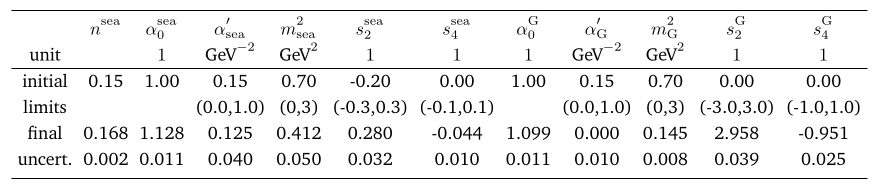

# Chi-squares

In [44]:
chid = {'DIS': ('\cite{H1:1996zow}', DISpoints, []),
        'DVCS': ('\cite{H1:2005gdw,H1:2009wnw,ZEUS:2003pwh,ZEUS:2008hcd}', DVCSpoints, []),
        'DVMP': ('\cite{H1:2009cml,ZEUS:2007iet}', DVMPpoints, []),
        'DVMP': ('\cite{H1:2009cml,ZEUS:2007iet}', DVMPpoints, [])}

In [45]:
%%time
for key, val in chid.items():
    for th in THEORIES:
        print('.', end='')
        val[-1].append(th.chisq(val[1]))
    print(' ', end='')
print()

...... ...... ...... 
CPU times: user 1min 11s, sys: 52.5 ms, total: 1min 11s
Wall time: 1min 11s


In [46]:
fmt = '{} & {} & {} & ' + 5*"{:.1f} & " + r'{:.1f} \\'   # 5 is len(THEORIES)-1
head_fmt = '{} & {} & {} & ' + 5*"{} & " + r'{} \\'

In [47]:
# This generates LaTeX table for paper:
# In final (DRAFT=False) version, references are inserted and chisq/npt larger
# than 5 should be entered as '>>1'
#
print(head_fmt.format('Dataset', 'Refs.', 'npts', *[th.name for th in THEORIES]))
total_chis = np.asarray(6*[0.])  # 6 is len(THEORIES)
total_pts = 0
for key, val in chid.items():
    npts, chis = len(val[1]), val[-1]
    chinpt = [chi/(npts) for chi in chis]
    if DRAFT:
        print(fmt.format(key, 'refs', npts, *chinpt))
    else:
        print(fmt.format(key, val[0], npts, *chinpt))
    total_chis += np.asarray(chis)
    total_pts += npts
total_chinpt = total_chis/total_pts
print(fmt.format('Total', '', total_pts, *total_chinpt))

Dataset & Refs. & npts & LO DVCS & LO DVMP & LO DVCS+DVMP & NLO DVCS & NLO DVMP & NLO DVCS+DVMP \\
DIS & \cite{H1:1996zow} & 85 & 0.6 & 0.6 & 0.6 & 0.8 & 0.8 & 0.8 \\
DVCS & \cite{H1:2005gdw,H1:2009wnw,ZEUS:2003pwh,ZEUS:2008hcd} & 27 & 0.4 & 12252.2 & 0.6 & 0.6 & 27269.6 & 0.8 \\
DVMP & \cite{H1:2009cml,ZEUS:2007iet} & 45 & 49.7 & 3.1 & 3.3 & 10.8 & 1.5 & 1.8 \\
Total &  & 157 & 14.6 & 2108.3 & 1.4 & 3.7 & 4690.6 & 1.1 \\


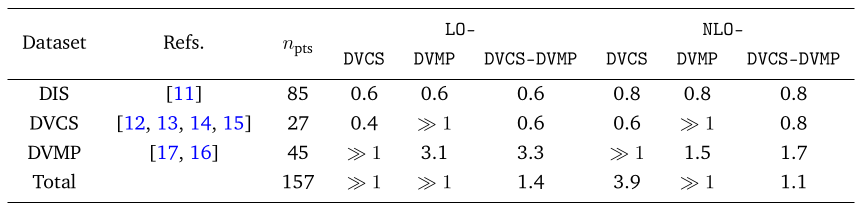

Chi-squares per degree of freedom

In [48]:
ALLpoints = DISpoints+DVCSpoints+DVMPpoints

In [49]:
print("chisq/dof (LO-DVCS-DVMP) = {:.1f}".format(th0.chisq(ALLpoints) / (len(ALLpoints) - 3 - 8)))

chisq/dof (LO-DVCS-DVMP) = 1.5


In [50]:
print("chisq/dof (NLO-DVCS-DVMP) = {:.1f}".format(th1.chisq(ALLpoints) / (len(ALLpoints) - 3 - 8)))

chisq/dof (NLO-DVCS-DVMP) = 1.2


Details of DVMP fit:

In [51]:
DVMP_Q2_H1_points = g.select(H1_rho_Q2, ['Q2 >= 10.0'])
DVMP_W_H1_points = g.select(H1_rho_W, ['Q2 >= 10.0'])
DVMP_Q2_ZEUS_points = g.select(ZEUS_rho_Q2, ['Q2 >= 10.0'])
DVMP_W_ZEUS_points = g.select(ZEUS_rho_W, ['Q2 >= 10.0'])

In [52]:
thm1.chisq(DVMPpoints), len(DVMPpoints)

(69.14949441431102, 45)

In [53]:
thm1.chisq(DVMP_Q2_points), len(DVMP_Q2_points)

(8.560267105432137, 17)

In [54]:
thm1.chisq(DVMP_Q2_ZEUS_points), len(DVMP_Q2_ZEUS_points)

(4.034519568311973, 6)

In [55]:
thm1.chisq(DVMP_Q2_H1_points), len(DVMP_Q2_H1_points)

(4.525747537120165, 11)

In [56]:
thm1.chisq(DVMP_W_points), len(DVMP_W_points)

(60.5892273088789, 28)

In [57]:
thm1.chisq(DVMP_W_ZEUS_points), len(DVMP_W_ZEUS_points)

(43.04463646890278, 13)

In [58]:
thm1.chisq(DVMP_W_H1_points), len(DVMP_W_H1_points)

(17.544590839976117, 15)

# Plots - comparison to the experiments

In [59]:
def line_label(dtset, extended=False):
    """Return location and label for dataset plotting."""
    pt = dtset[-1]  # last point
    y = pt.val
    d = pt.W - dtset[-2].W  # distance between last two points
    x = pt.W + d/5
    if extended:
        return x, y, r'$\mathcal{{Q}}^2 = {}\:\mathrm{{GeV}}^2$'.format(pt.Q2)
    else:
        return x, y, r'${}\:\mathrm{{GeV}}^2$'.format(pt.Q2)
    # return x, y, '{}'.format(pt.Q2)

In [60]:
# H1 rho
def dvmp_H1_fig(ths, draft=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 3], sharey=True)
    if draft:
        Q2cut = 1.
    else:  # plot only what is used in analysis
        Q2cut = 10.
    dtset = H1_rho_Q2
    dtset_red = g.select(dtset, ['Q2 >= {}'.format(Q2cut)])
    ax1.errorbar(dtset_red.df().Q2.values, dtset_red.df().val.values,
                 yerr=dtset_red.df().err.values, color='black',
                marker='o', linestyle='None', label='H1+R, W = 75 GeV')
    for TH in ths:
        ax1.plot(dtset_red.df().Q2.values, 
                 [TH.predict(pt) for pt in dtset_red], label=TH.name, **TH.props)
    ax1.set_yscale('log')
    ax1.set_ylim(0.1, 180)
    ax1.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
    ax1.set_ylabel(r'$\sigma (\gamma_{\rm L}^* \textup{p} \to \rho^{0} \textup{p})\;[\mathrm{nb}]$')
    if draft:
        ax1.text(0.04, 0.04, "H1 Tbl. 14\nGepard ID=606\n(+ R)", 
                bbox=dict(boxstyle="round", ec="red", fc="white"), transform=ax1.transAxes)
    ax1.legend(loc='upper right', handlelength=4.0, handleheight=0.2)#.draw_frame(0)
    EXT = True
    for ln in range(4):  # lines for each Q^2
        dtset = H1_rho_W[ln*5:(ln+1)*5]
        Q2 = dtset[0].Q2
        if Q2 > Q2cut:
            if EXT:
                ax2.errorbar(dtset.df().W.values, dtset.df().val.values, 
                    yerr=dtset.df().err.values, color='black',
                    marker='o', linestyle='None', label='H1 + R')
            else:
                ax2.errorbar(dtset.df().W.values, dtset.df().val.values, 
                    yerr=dtset.df().err.values, color='black',
                    marker='o', linestyle='None')
            ax2.text(*line_label(dtset, EXT))
            EXT = False
            for TH in ths:
                if ln == 3:
                    ax2.plot(dtset.df().W.values,
                             [TH.predict(pt) for pt in dtset], label=TH.name, **TH.props)
                else:
                    ax2.plot(dtset.df().W.values,
                             [TH.predict(pt) for pt in dtset], **TH.props)
    ax2.set_yscale('log')
    ax2.set_xlim(50, 200)
    ax2.set_xlabel('$W\;[\mathrm{GeV}]$')
    if draft:
        ax2.text(0.04, 0.04, "H1 Tbl. 21\nGepard ID=79\n(+ R)", 
                bbox=dict(boxstyle="round", ec="red", fc="white"), transform=ax2.transAxes)
    # ax2.legend(loc='lower right', handlelength=3)
    fig.canvas.draw()
    return fig

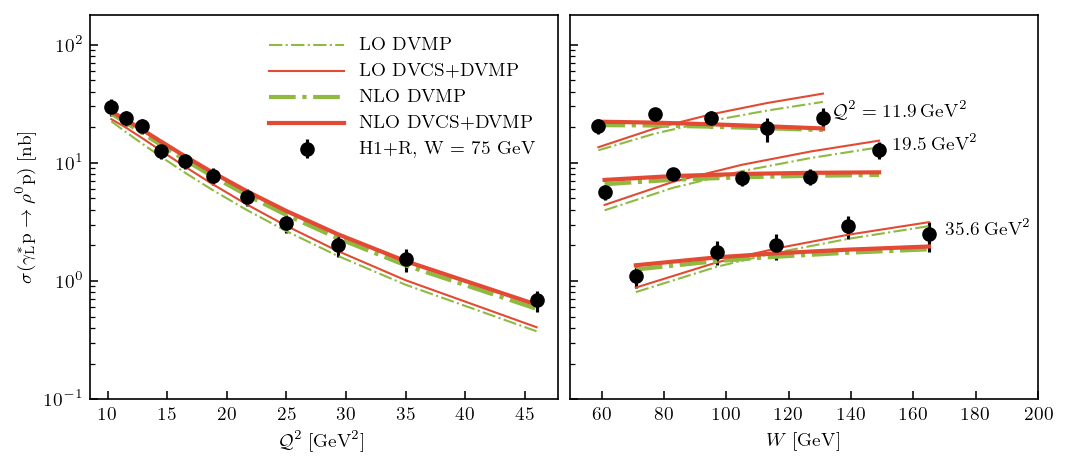

In [61]:
fig = dvmp_H1_fig([thm0, th0, thm1, th1], draft=DRAFT)

In [62]:
fig.savefig('{}/H1_dvmp.pdf'.format(FIGDIR))
# fig.savefig('{}/H1_dvmp.png'.format(FIGDIR))

In [63]:
# ZEUS rho
def dvmp_ZEUS_fig(ths, draft=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 3], sharey=True)
    if draft:
        Q2cut = 1.
    else:  # plot only what is used in analysis
        Q2cut = 10.
    dtset = ZEUS_rho_Q2
    dtset_red = g.select(dtset, ['Q2 >= {}'.format(Q2cut)])
    ax1.errorbar(dtset_red.df().Q2.values, dtset_red.df().val.values, yerr=dtset_red.df().err.values,
                color='black', marker='o', linestyle='None', label='ZEUS+R, W = 90 GeV')
    for TH in ths:
        ax1.plot(dtset_red.df().Q2.values, 
                 [TH.predict(pt) for pt in dtset_red], label=TH.name, **TH.props)
    ax1.set_yscale('log')
    ax1.set_ylim(0.008, 180)
    ax1.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
    ax1.set_ylabel(r'$\sigma (\gamma_{\rm L}^* \textup{p} \to \rho^{0} \textup{p})\;[\mathrm{nb}]$')
    if draft:
        ax1.text(0.04, 0.04, "ZEUS Tbl. 4\nGepard ID=607\n(+ R)", 
                bbox=dict(boxstyle="round", ec="red", fc="white"), transform=ax1.transAxes)
    ax1.legend(loc='upper right', handlelength=3.5)#.draw_frame(0)
    EXT = True
    for ln in range(4):  # lines for each Q^2
        ranges = [(0,5), (5,10), (10, 16), (16,23)]
        dtset = ZEUS_rho_W[ranges[ln][0]:ranges[ln][1]]
        Q2 = dtset[0].Q2   
        if Q2 > Q2cut:
            if EXT:
                ax2.errorbar(dtset.df().W.values, dtset.df().val.values, 
                    yerr=dtset.df().err.values, color='black',
                    marker='o', linestyle='None', label='ZEUS + R')
            else:
                ax2.errorbar(dtset.df().W.values, dtset.df().val.values, 
                    yerr=dtset.df().err.values, color='black',
                    marker='o', linestyle='None')
            ax2.text(*line_label(dtset, EXT))
            EXT = False
            for TH in ths:
                if ln == 3:
                    ax2.plot(dtset.df().W.values, [TH.predict(pt) for pt in dtset],
                             label=TH.name, **TH.props)
                else:
                    ax2.plot(dtset.df().W.values, [TH.predict(pt) for pt in dtset],
                             **TH.props)
    ax2.set_yscale('log')
    ax2.set_xlim(40, 205)
    ax2.set_xlabel('$W\;[\mathrm{GeV}]$')
    if draft:
        ax2.text(0.04, 0.04, "ZEUS Tbl. 5\nGepard ID=608\n(+ R)", 
                bbox=dict(boxstyle="round", ec="red", fc="white"), transform=ax2.transAxes)
    # ax2.legend(loc='lower right', handlelength=3).draw_frame(0)
    fig.canvas.draw()
    return fig

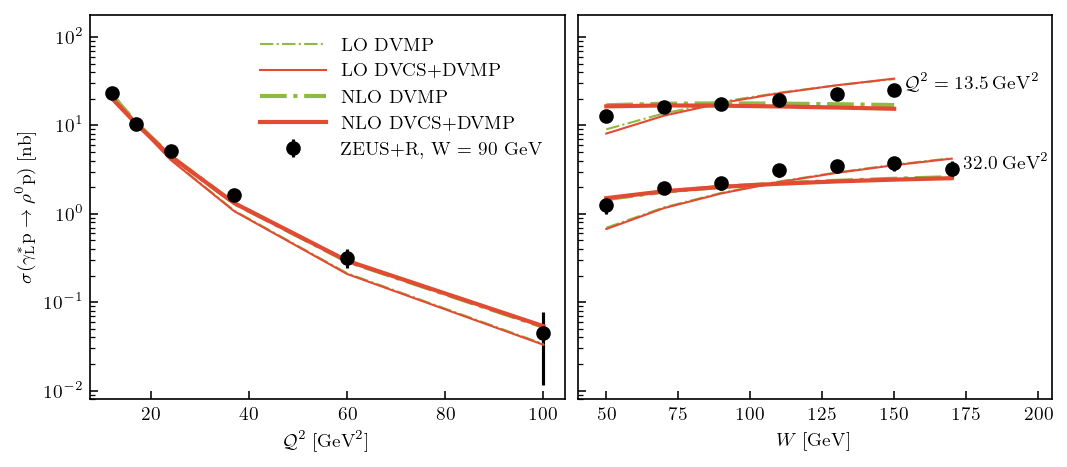

In [64]:
fig = dvmp_ZEUS_fig([thm0, th0, thm1, th1], draft=DRAFT)

In [65]:
fig.savefig('{}/ZEUS_dvmp.pdf'.format(FIGDIR))
# fig.savefig('{}/ZEUS_dvmp.png'.format(FIGDIR))

We do not fit to nor consider t-dependence of DVMP data due to lack of information about t-dependence
of L-T separation ratio R. So the next plot is just a sanity check that t-dependence is not
completely crazy.

In [66]:
# H1 rho - t dep
def dvmp_H1t_fig(ths, draft=False, file=False):
    fig, ax2 = plt.subplots(1, 1, figsize=[4, 4])
    for ln in range(4):  # lines for each Q^2
        dtset = H1_rho_t[ln*7:(ln+1)*7]
        Q2 = dtset[0].Q2
        ax2.errorbar(dtset.df().tm.values, dtset.df().val.values, 
                    yerr=dtset.df().err.values,
                    marker='o', linestyle='None')
                    # label=r'$Q^2 = {}\:\mathrm{{GeV}}^2$'.format(Q2))
        if Q2 > 10:
            for TH in ths:
                if ln == 3:
                    ax2.plot(dtset.df().tm.values,
                             [TH.predict(pt) for pt in dtset], label=TH.name, **TH.props)
                else:
                    ax2.plot(dtset.df().tm.values,
                             [TH.predict(pt) for pt in dtset], **TH.props)
    ax2.set_yscale('log')
    ax2.set_xlabel('$-t\;[\mathrm{GeV}^2]$')
    ax2.set_ylabel(r'$d\sigma (\gamma_{\rm L}^* \textup{p} \to \rho^{0} \textup{p})/dt \;[\mathrm{nb}/\mathrm{GeV}^2]$')
    if DRAFT:
        ax2.text(0.1, 0.1, "H1 Tbl. 26\nGepard ID=75\n(+ R)", 
                bbox=dict(boxstyle="round", ec="red", fc="white"), transform=ax2.transAxes)
    ax2.legend(loc='upper right', handlelength=3)
    if file:
        fig.savefig(file)
    else:
        fig.canvas.draw()

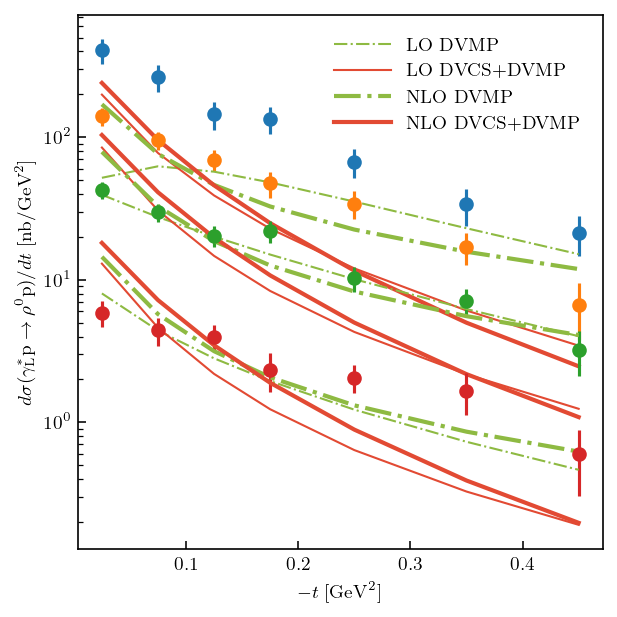

In [67]:
dvmp_H1t_fig([thm0, th0, thm1, th1])

In [68]:
def dvcs_fig(ths):
    """Makes plot of H1 and ZEUS DVCS data with fit lines"""
    subsets = {}
    subsets[1] = [g.select(g.dset[63], criteria=['Q2 == 8.']),
            g.select(g.dset[63], criteria=['Q2 == 15.5']),
            g.select(g.dset[63], criteria=['Q2 == 25.'])]
    subsets[2] = [g.dset[46]] # ZEUS t-dep
    subsets[3] = [g.dset[48],
            g.select(g.dset[41], criteria=['Q2 == 8.']),
            g.select(g.dset[41], criteria=['Q2 == 15.5']),
            g.select(g.dset[41], criteria=['Q2 == 25.'])]
    subsets[4] = [g.dset[47]] # ZEUS Q2-dep
    xs = ['tm', 'tm', 'W', 'Q2']
    fig, (axu, axl) = plt.subplots(2, 2, figsize=[7, 5], sharey=True)
    for npanel in range(1,5):
        if npanel < 3:
            ax = axu[npanel-1]
        else:
            ax = axl[npanel-3]
        xvar = xs[npanel-1]
        for dtset in subsets[npanel]:
            ax.errorbar(dtset.df()[xvar].values, dtset.df().val.values, 
                yerr=dtset.df().err.values,# color='black',
                marker='o', linestyle='None')
            for TH in ths:
                ax.plot(dtset.df()[xvar].values,
                         [TH.predict(pt) for pt in dtset], label=TH.name, **TH.props)
        ax.set_yscale('log')  # y-axis to be logarithmic
        if npanel < 3:
            ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
        # y labels
        if npanel==1:
            ax.set_ylabel(r'$d\sigma_{\gamma}/dt\; [{\rm nb/GeV}^2]$')
        elif npanel==3:
            ax.set_ylabel(r'$\sigma_{\gamma}\; [{\rm nb}]$')
        else: # npanel 4
            ax.set_ylabel('')
        # x labels
        if npanel==1 or npanel==2:
            ax.set_xlabel(r'$-t\quad [{\rm GeV}^2]$')
        elif npanel==3:
            ax.set_xlabel(r'$W\quad [{\rm GeV}]$')
        else: # npanel 4
            ax.set_xlabel(r'$\mathcal{Q}^2\quad [{\rm GeV}^2]$')
        if npanel==1:
            ax.text(0.5, 22, r'H1 \\ ${\rm W = 82}\, {\rm GeV}$ \\ $\mathcal{Q}^2\!= 8,\, 15.5,\, 25\,{\rm GeV}^2$')
        elif npanel==2:
            ax.text(0.27, 1, r'ZEUS \\ ${\rm W = 104}\, {\rm GeV}$ \\ $\mathcal{Q}^2\!= 3.2\,{\rm GeV}^2$')
            # ax.text(0.3, 3.5, r'${\rm W = 104}\, {\rm GeV}$')
            # ax.text(0.3, 2.1, r'$\mathcal{Q}^2\!= 3.2\\,{\rm GeV}^2$')
        elif npanel==3:
            ax.text(45, 30, r'${\rm ZEUS}\, (idem):$')
            ax.text(45, 5.5, r'${\rm H1}\, (idem):$')
        else: # npanel==4
            ax.legend(loc="upper right")
            ax.text(45, 1.5, r'ZEUS \\ ${\rm W = 104}\, {\rm GeV}$')
            #ax.set_xlim(0, 80)
    return fig

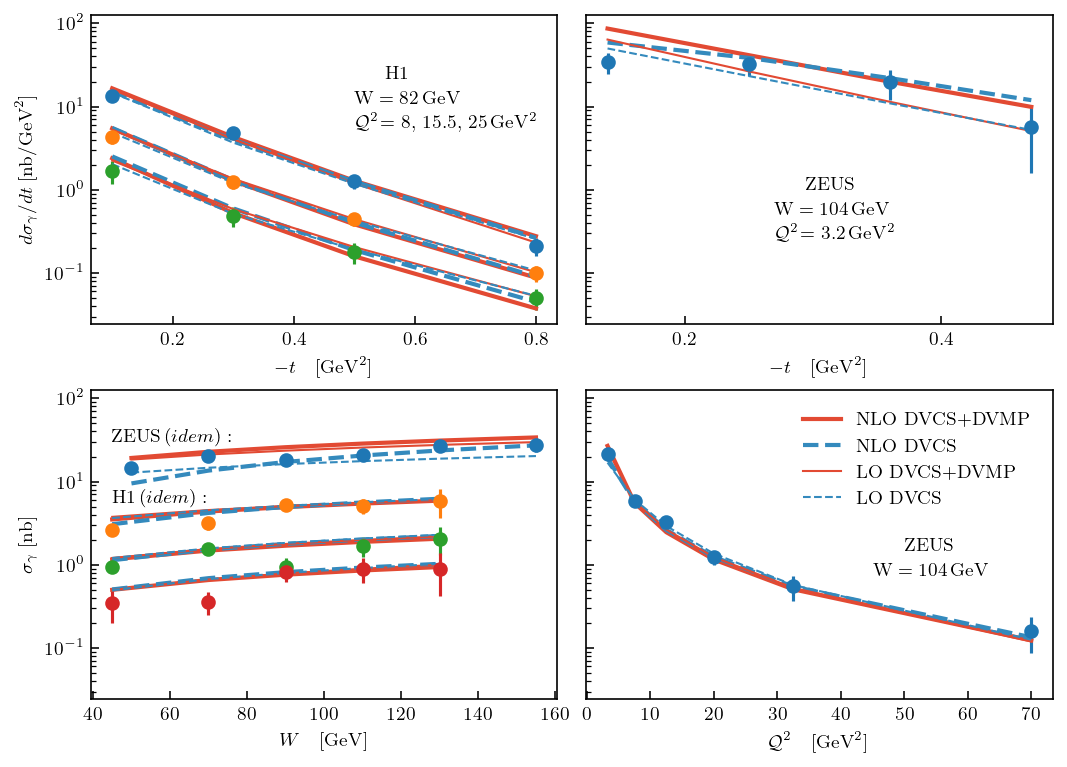

In [69]:
fig = dvcs_fig([th1, thz1, th0, thz0])

In [70]:
fig.savefig('{}/H1ZEUS_dvcs.pdf'.format(FIGDIR))
# fig.savefig('{}/H1ZEUS_dvcs.png'.format(FIGDIR))

In [71]:
def line_label_xB(dtset, extended=False):
    """Return location and label for dataset plotting."""
    pt = dtset[-1]  # last point
    y = pt.val
    d = pt.Q2 - dtset[-2].Q2  # distance between last two points
    x = pt.Q2 + d/5
    if extended:
        return x, y, r'  $. \,x_{{\rm B}} = {}$'.format(pt.xB)
    else:
        return x, y, r'${}$'.format(pt.xB)
    # return x, y, '{}'.format(pt.Q2)

In [72]:
def dis_F2_fig(ths):
    fig, ax = plt.subplots(1, 1, figsize=[4, 3])
    dtsets = [g.dset[208], g.dset[206], g.dset[204], g.dset[202]]
    EXT = True
    for dtset in dtsets:
        xB = dtset[0].xB
        if EXT:
            ax.errorbar(dtset.df().Q2.values, dtset.df().val.values, 
                yerr=dtset.df().err.values, color='black',
                marker='o', linestyle='None', label='H1')
            for TH in ths:
                ax.plot(dtset.df().Q2.values,
                         [TH.predict(pt) for pt in dtset], label=TH.name, **TH.props)
        else:
            ax.errorbar(dtset.df().Q2.values, dtset.df().val.values, 
                yerr=dtset.df().err.values, color='black',
                marker='o', linestyle='None')
            for TH in ths:
                ax.plot(dtset.df().Q2.values,
                         [TH.predict(pt) for pt in dtset], **TH.props)
        ax.text(*line_label_xB(dtset, EXT))
        EXT = False
    ax.set_xlim(0, 115)
    ax.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$')
    ax.set_ylabel(r'$F_{2}^{\rm p}(x_{\rm B}, Q^2)$')
    ax.legend(loc='upper right', handlelength=2.5)
    return fig

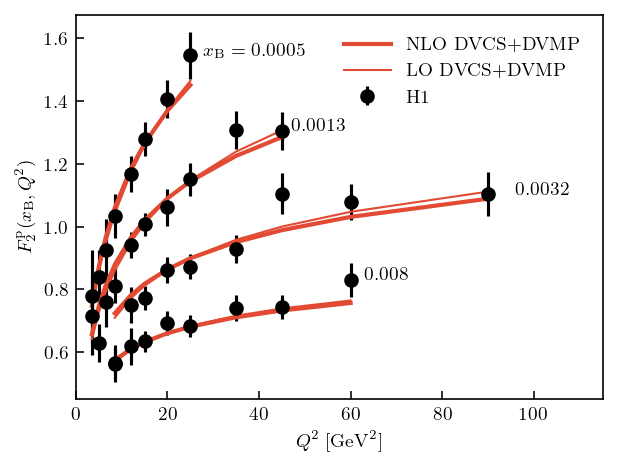

In [73]:
fig = dis_F2_fig([th1, th0])

In [74]:
fig.savefig('{}/H1_dis.pdf'.format(FIGDIR))
# fig.savefig('{}/H1_dis.png'.format(FIGDIR))

## $Q^2$ scaling - fixed W

In [75]:
Q2points = g.select(H1_rho_Q2, ['Q2 >= 10.0'])

In [76]:
logQ2 = np.log10(Q2points.df().Q2.values)
logSigL = np.log10(Q2points.df().val.values)

In [77]:
logerr = Q2points.df().err.values / Q2points.df().val.values / np.log(10)

In [78]:
logpred1 = np.array([np.log10(thm1.predict(pt)) for pt in Q2points])
logpred0 = np.array([np.log10(thm0.predict(pt)) for pt in Q2points])

In [79]:
def model(x, a, b):
    return a + b*x

parexp, cov = curve_fit(model, logQ2, logSigL)
print("Power of Q (experiment) = {:.2} +- {:.1}".format(2*parexp[1], 2*np.sqrt(cov[1, 1])))

pars, cov = curve_fit(model, logQ2, logpred1)
print("Power of Q  (NLO fit) = {:.2} +- {:.1}".format(2*pars[1], 2*np.sqrt(cov[1, 1])))

pars, cov = curve_fit(model, logQ2, logpred0)
print("Power of Q (LO fit) = {:.2} +- {:.1}".format(2*pars[1], 2*np.sqrt(cov[1, 1])))

Power of Q (experiment) = -5.1 +- 0.1
Power of Q  (NLO fit) = -5.1 +- 0.2
Power of Q (LO fit) = -5.5 +- 0.2


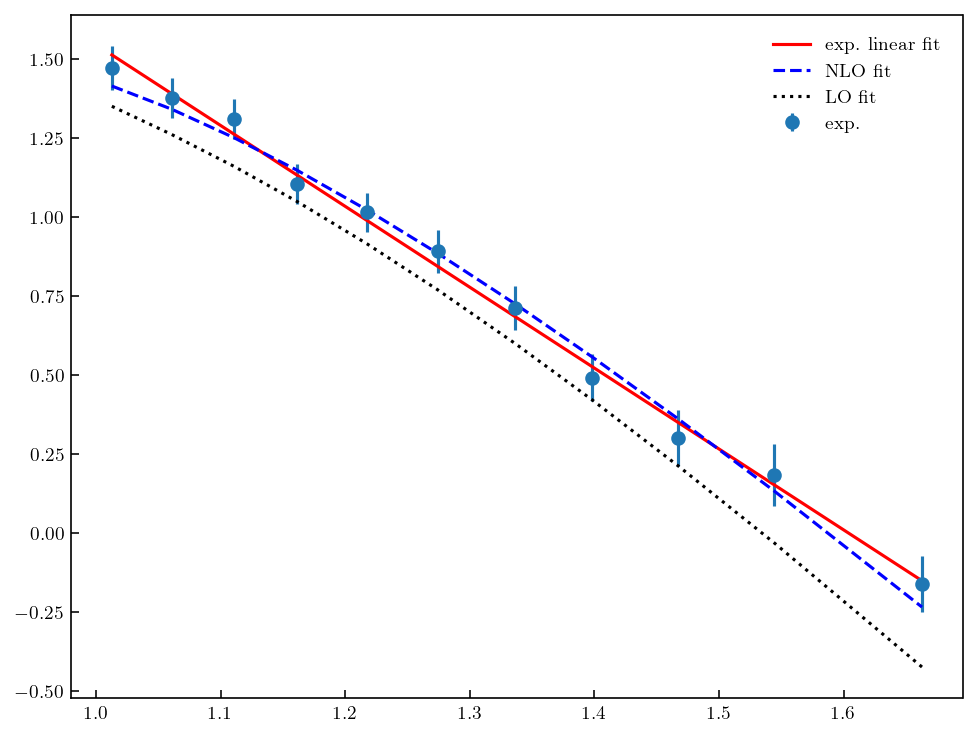

In [80]:
#plt.plot(logQ2, logSigL, 'o', label='$\sigma_L$')
plt.errorbar(logQ2, logSigL, yerr=logerr, marker='o', linestyle='None', label='exp.')
plt.plot(logQ2, parexp[0] + parexp[1]*logQ2, 'r', label='exp. linear fit')
plt.plot(logQ2, logpred1, 'b--', label='NLO fit')
plt.plot(logQ2, logpred0, 'k:', label='LO fit')
plt.legend()
plt.show()

In [81]:
def DVMP_scaling(ths, draft=False):                                                                       
    fig, ax1 = plt.subplots(1, 1, figsize=[4.5, 3])                                                                     
    fac = (np.sqrt(2)*g.constants.F_phi/g.constants.F_rho0/3)**2                                                      
    rho_vals = H1_rho_Q2.df().Q2.values**(2.5)*H1_rho_Q2.df().val.values                                              
    rho_errs = H1_rho_Q2.df().Q2.values**(2.5)*H1_rho_Q2.df().err.values                                              
    ax1.errorbar(H1_rho_Q2.df().Q2.values, rho_vals, yerr=rho_errs,                                                   
                marker='o', color='black', linestyle='None', label=r'$\rho^0$')                                                      
    for TH in ths:                                                                                                    
        dtset_rho = g.select(H1_rho_Q2, ['Q2 >= 10.'])                                                                
        rho_preds = [TH.predict(pt) for pt in dtset_rho]                                                              
        rho_preds = dtset_rho.df().Q2.values**(2.5)*np.array(rho_preds)                                               
        ax1.plot(dtset_rho.df().Q2.values, rho_preds, label=TH.name, **TH.props)                                      
    dtset_phi = H1_phi_Q2                                                                                             
    phi_vals = dtset_phi.df().Q2.values**(2.5)*dtset_phi.df().val.values/fac                                          
    phi_errs = dtset_phi.df().Q2.values**(2.5)*dtset_phi.df().err.values/fac                                          
    ax1.errorbar(dtset_phi.df().Q2.values, phi_vals, yerr=phi_errs, marker='v', linestyle='None',
                 color=bel_cmap['bel_blue'],
                 label=r'$\phi\times (3 f_{\rho^0}/\sqrt{2} f_{\phi})^2$')                                     
    ax1.set_yscale('log')                                                                                             
    ax1.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')                                                            
    ax1.set_ylabel(r'$\mathcal{Q}^5\sigma(\gamma_{\rm L}^* \textup{p} \to \textup{V} \textup{p})\;[\mathrm{nb}]$')                                                                                        
    ax1.set_ylim(1000, 20000)                                                                                         
    ax1.legend(loc='lower right', handlelength=3.5)                                                                   
    return fig

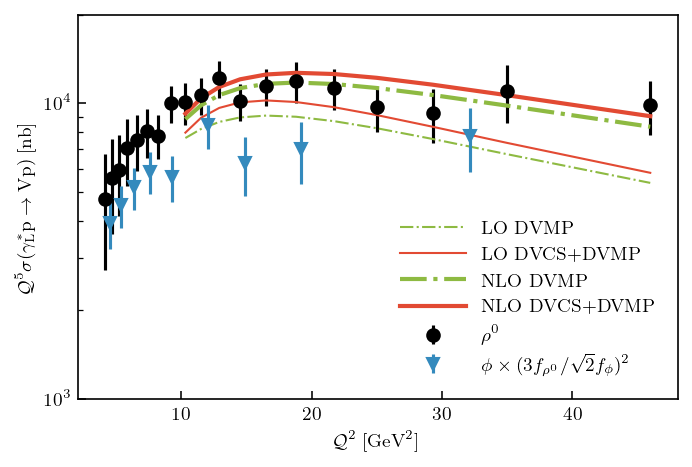

In [82]:
fig = DVMP_scaling([thm0, th0, thm1, th1])

In [83]:
fig.savefig('{}/Q2Wscaling.pdf'.format(FIGDIR))

## $Q^2$ scaling - fixed $x_B$ - asymptotic behaviour

In [84]:
H1_rho_W = sigtot2sigL(g.dset[79], collaboration='H1')

In [85]:
# Q2points = g.select(g.dset[79], ['xB >= 0.0015', 'xB <= 0.0025']) # sigma_tot

In [86]:
Q2points = g.select(H1_rho_W, ['xB >= 0.0015', 'xB <= 0.0025'])  # sigma_L

In [87]:
print('Mean xB = {:.4f} +- {:.4f}'.format(Q2points.df().xB.values.mean(), Q2points.df().xB.values.std()))

Mean xB = 0.0018 +- 0.0001


In [88]:
logQ2 = np.log10(Q2points.df().Q2.values)
logSigL = np.log10(Q2points.df().val.values)

In [89]:
logerr = Q2points.df().err.values / Q2points.df().val.values / np.log(10)

In [90]:
def model(x, a, b):
    return a + b*x

parexp, cov = curve_fit(model, logQ2, logSigL)
print("Power of Q (experiment) = {:.2} +- {:.1}".format(2*parexp[1], 2*np.sqrt(cov[1, 1])))

Power of Q (experiment) = -3.8 +- 0.2


In [91]:
Q2s = np.logspace(1, np.log10(400), 20)
logQ2s = np.log10(Q2s)
cpts = []
for Q2 in Q2s:
    cpts.append(g.DataPoint(process='gammastarp2rho0p', observable='XGAMMA', xB=0.0018, Q2=Q2, tmmax=0.5,
                 process_class='DVMP'))
    # cpts.append(g.DataPoint(process='gammastarp2rho0p', observable='XGAMMA', xB=0.002, Q2=Q2, t=-0.1,
    #              process_class='DVMP'))
cpts = g.DataSet(cpts)

In [92]:
%%time
logpred1 = np.array([np.log10(thm1.predict(pt)) for pt in cpts])
logpred0 = np.array([np.log10(thm0.predict(pt)) for pt in cpts])

CPU times: user 44.2 s, sys: 23.1 ms, total: 44.3 s
Wall time: 44.4 s


In [93]:
loind=7
hiind=-7

In [94]:
pars, cov = curve_fit(model, logQ2s[:loind], logpred0[:loind])
print("Power of low-Q (LO fit) = {:.2} +- {:.1}".format(2*pars[1], 2*np.sqrt(cov[1, 1])))

pars, cov = curve_fit(model, logQ2s[:loind], logpred1[:loind])
print("Power of low-Q  (NLO fit) = {:.2} +- {:.1}".format(2*pars[1], 2*np.sqrt(cov[1, 1])))

Power of low-Q (LO fit) = -3.6 +- 0.2
Power of low-Q  (NLO fit) = -4.3 +- 0.1


In [95]:
pars, cov = curve_fit(model, logQ2s[hiind:], logpred0[hiind:])
print("Power of high-Q (LO fit) = {:.2} +- {:.1}".format(2*pars[1], 2*np.sqrt(cov[1, 1])))

pars, cov = curve_fit(model, logQ2s[hiind:], logpred1[hiind:])
print("Power of high-Q  (NLO fit) = {:.2} +- {:.1}".format(2*pars[1], 2*np.sqrt(cov[1, 1])))

Power of high-Q (LO fit) = -5.6 +- 0.02
Power of high-Q  (NLO fit) = -5.7 +- 0.01


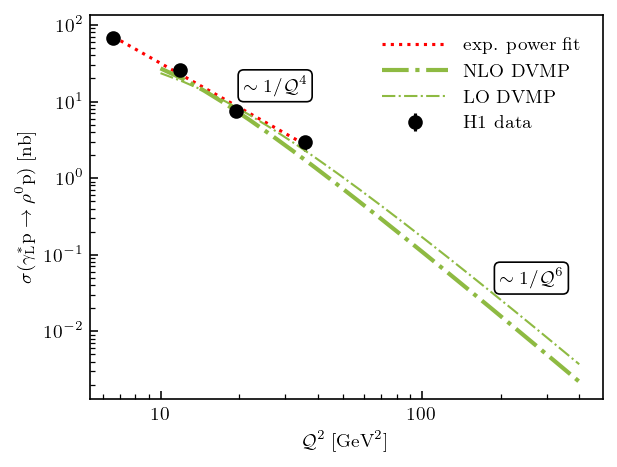

In [96]:
fig, ax = plt.subplots(1, 1, figsize=[4, 3])
ax.errorbar(Q2points.df().Q2.values, Q2points.df().val.values, 
            yerr=Q2points.df().err.values, marker='o', color='black',
            linestyle='None', label='H1 data')
fitsig = 10**parexp[0] * Q2points.df().Q2.values**(parexp[1])
ax.plot(Q2points.df().Q2.values, fitsig, 'r:', label='exp. power fit')
ax.plot(Q2s, 10**logpred1, label=thm1.name, **thm1.props)
ax.plot(Q2s, 10**logpred0, label=thm0.name, **thm0.props)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\sigma (\gamma_{\rm L}^* \textup{p} \to \rho^{0} \textup{p})\;[\mathrm{nb}]$')
ax.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.legend(handlelength=3.5)
ax.text(0.3, 0.8, "$\sim 1/\mathcal{Q}^4$", 
                bbox=dict(boxstyle="round", ec="black", fc="white"), transform=ax.transAxes)
ax.text(0.8, 0.3, "$\sim 1/\mathcal{Q}^6$", 
                bbox=dict(boxstyle="round", ec="black", fc="white"), transform=ax.transAxes)
fig.canvas.draw()

In [97]:
fig.savefig('{}/Q2scaling.pdf'.format(FIGDIR))

exp. points are essentially Fig. 6b in Favart et al. EPJA review, but for longitudinal cross section. 

# Plots - Quarks and Gluons

For the purposes of plotting particular GPDs, we are defining a new GPD model, where we can independently set to zero quarks and gluons. This is not possible in the usual `PWNormGPD` where normalization of gluons is fixed by that of quarks and momentum sum-rule.

In [98]:
def singlet_ng_unconstrained(j: np.ndarray, t: float, par: dict,
                           residualt: str = 'dipole') -> np.ndarray:
    """Same as constrained, but with free ng parameter."""
    # par['ng'] = 0.6 - par['ns']  # first sum-rule constraint
    if residualt == 'dipole':
        tdep_s = g.gpd.betadip(j, t, par['ms2'], 0., 2)
        tdep_g = g.gpd.betadip(j, t, par['mg2'], 0., 2)
    elif residualt == 'exp':
        tdep_s = g.gpd.betaexp(t, par['ms2'])
        tdep_g = g.gpd.betaexp(t, par['mg2'])
    else:
        raise ValueError("{} unknown. Use 'dipole' or 'exp'".format(residualt))

    singlet = (g.gpd.qj(j, t, 9, par['ns'], par['al0s'], par['alps']) * tdep_s)
    gluon = (g.gpd.qj(j, t, 7, par['ng'], par['al0g'], par['alpg']) * tdep_g)
    return np.array((singlet, gluon, np.zeros_like(gluon), np.zeros_like(gluon)))

The function above is the only difference to stock Gepard, everything else is inherited from `PWNormGPD`:

In [99]:
class UnconstrainedGPD(g.PWNormGPD):
    def H(self, eta: float, t: float) -> np.ndarray:
        """Return (npts, 4) array H_j^a for all j-points and 4 flavors."""
        return singlet_ng_unconstrained(self.jpoints,
                                        t, self.parameters, self.residualt).transpose()

In [100]:
class UnconstrainedTheory(UnconstrainedGPD, g.cff.MellinBarnesCFF, g.KellyEFF, g.dvcs.BMK, g.dvmp.MellinBarnesTFF, g.dvmp.DVMP, g.DIS):
    pass

We now define a function that takes theory object (with constrained gluons) and returns tuple of two theory objects,
one where gluons are set to zero, and another where quarks are.

In [101]:
def quarks_gluons_th(th):
    """Return tuple of (quark only, gluon only) theory instances."""
    thu_quark = UnconstrainedTheory(p=th.p)
    thu_gluon = UnconstrainedTheory(p=th.p)
    for thu in [thu_quark, thu_gluon]:
        thu.parameters = copy.deepcopy(th.parameters)
        thu.parameters['ng'] = 0.6 - th.parameters['ns']
    thu_quark.parameters['ng'] = 0
    thu_gluon.parameters['ns'] = 0
    return(th, thu_quark, thu_gluon)

In [102]:
th0s = quarks_gluons_th(th0)
th1s = quarks_gluons_th(th1)

In [103]:
xB = 0.001
NPTS = 20
Q2vals = np.logspace(np.log10(4.), np.log10(80), NPTS)

In [104]:
%%time
DISF2s = []
for Q2 in Q2vals:
    pt = g.DataPoint(xB=xB, t=0, Q2=Q2)
    dis_los = [th.DISF2(pt) for th in th0s]
    dis_nlos = [th.DISF2(pt) for th in th1s]
    DISF2s.append((dis_los, dis_nlos))
DISF2s = np.array(DISF2s)

CPU times: user 9.6 s, sys: 6.6 ms, total: 9.6 s
Wall time: 9.62 s


In [105]:
%%time
ImHs = []
for Q2 in Q2vals:
    pt = g.DataPoint(xB=xB, t=0, Q2=Q2)
    los = [th.ImH(pt) for th in th0s]
    nlos = [th.ImH(pt) for th in th1s]
    ImHs.append((los, nlos))
ImHs = np.array(ImHs)

CPU times: user 2min 12s, sys: 29.7 ms, total: 2min 12s
Wall time: 2min 12s


In [106]:
%%time
ReHs = []
for Q2 in Q2vals:
    pt = g.DataPoint(xB=xB, t=0, Q2=Q2)
    los = [th.ReH(pt) for th in th0s]
    nlos = [th.ReH(pt) for th in th1s]
    ReHs.append((los, nlos))
ReHs = np.array(ReHs)

CPU times: user 40.1 ms, sys: 3.28 ms, total: 43.4 ms
Wall time: 41.5 ms


In [107]:
%%time
ImHVs = []
for Q2 in Q2vals:
    pt = g.DataPoint(xB=xB, t=0, Q2=Q2, process='gammastarp2rho0p')
    dvmp_los = [th.ImH_V(pt) for th in th0s]
    dvmp_nlos = [th.ImH_V(pt) for th in th1s]
    ImHVs.append((dvmp_los, dvmp_nlos))
ImHVs = np.array(ImHVs)

CPU times: user 2min 16s, sys: 29.6 ms, total: 2min 16s
Wall time: 2min 17s


In [108]:
%%time
ReHVs = []
for Q2 in Q2vals:
    pt = g.DataPoint(xB=xB, t=0, Q2=Q2, process='gammastarp2rho0p')
    dvmp_los = [th.ReH_V(pt) for th in th0s]
    dvmp_nlos = [th.ReH_V(pt) for th in th1s]
    ReHVs.append((dvmp_los, dvmp_nlos))
ReHVs = np.array(ReHVs)

CPU times: user 33.3 ms, sys: 0 ns, total: 33.3 ms
Wall time: 31.9 ms


In [109]:
DECORATION = True

In [110]:
lw = 1.5
if DECORATION:
    titlebox = dict(boxstyle="round", ec="black", lw=0.5, fc="white")
    TITLESIZE = 25
else:
    titlebox = dict(boxstyle="square", alpha=0)
    TITLESIZE = 20

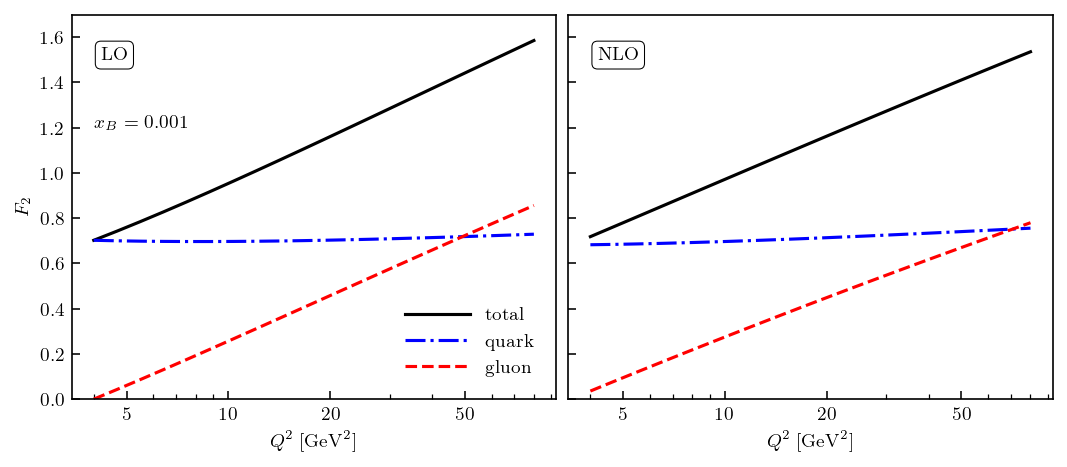

In [111]:
fig, axs = plt.subplots(1, 2, figsize=[7, 3], sharey=True)
ax1, ax2 = axs
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, DISF2s[:,0,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax1.set_xscale('log')
#ax1.set_ylim(0, 2.5)
ax1.axhline(y=0, lw=0.5, color='k')
ax1.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$')
ax1.set_ylabel(r'$F_2$')
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(4, 1.2, r'$x_B = {}$'.format(xB))
ax1.text(4.2, 1.5, "LO", bbox=titlebox)
ax1.legend(loc='lower right', handlelength=3.5)
#
for ln in range(3):
    ax2.plot(Q2vals, DISF2s[:,1,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax2.set_xscale('log')
ax1.set_ylim(0, 1.7)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$')
ax2.text(4.2, 1.5, "NLO", bbox=titlebox)
ax2.set_ylim(0, 1.7)
fig.canvas.draw()

In [112]:
fig.savefig('{}/QvsG_DIS.pdf'.format(FIGDIR))
# fig.savefig('{}/QvsG_DIS.png'.format(FIGDIR))

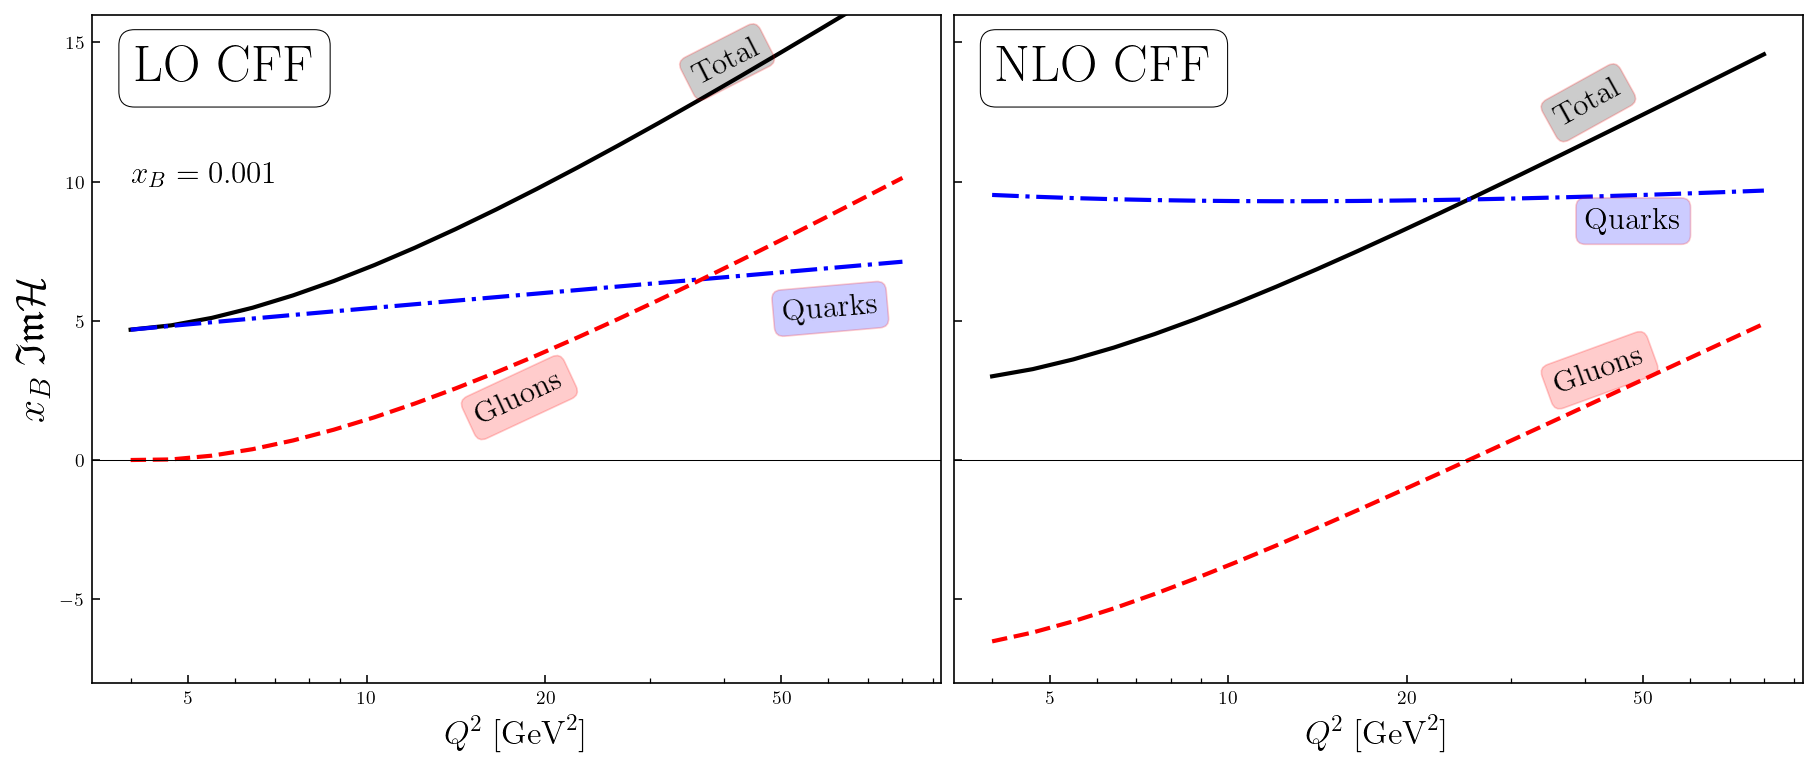

In [113]:
lw=2
fig, axs = plt.subplots(1, 2, figsize=[12, 5], sharey=True)
ax1, ax2 = axs
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ImHs[:,0,ln], styles[ln], lw=lw,
             label='LO {}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-8, 16)
ax1.axhline(y=0, linewidth=0.5, color='k')
ax1.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax1.set_ylabel(r'$x_B\:  \mathfrak{Im}\mathcal{H}$', fontsize=20)
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(4, 10, r'$x_B = {}$'.format(xB), fontsize=15)
ax1.text(35, 13.5, "Total", size=15, rotation=27.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax1.text(50, 5.0, "Quarks", size=15, rotation=5.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax1.text(15, 1.3, "Gluons", size=15, rotation=25.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax1.text(0.05, 0.9, "LO CFF", size=TITLESIZE,
         bbox=titlebox, transform=ax1.transAxes)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ImHs[:,1,ln], styles[ln], lw=lw,
             label='NLO {}'.format(names[ln]))
ax2.set_xscale('log')
# ax2.set_ylim(0, 2.5)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax2.text(35, 12, "Total", size=15, rotation=29.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax2.text(40, 8.3, "Quarks", size=15, rotation=0.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax2.text(35, 2.4, "Gluons", size=15, rotation=20.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax2.text(0.05, 0.9, "NLO CFF", size=TITLESIZE,
         bbox=titlebox, transform=ax2.transAxes)
fig.canvas.draw()

In [114]:
# fig.savefig('{}/QvsG_DVCS_imag.pdf'.format(FIGDIR))
# fig.savefig('{}/QvsG_DVCS_imag.png'.format(FIGDIR))

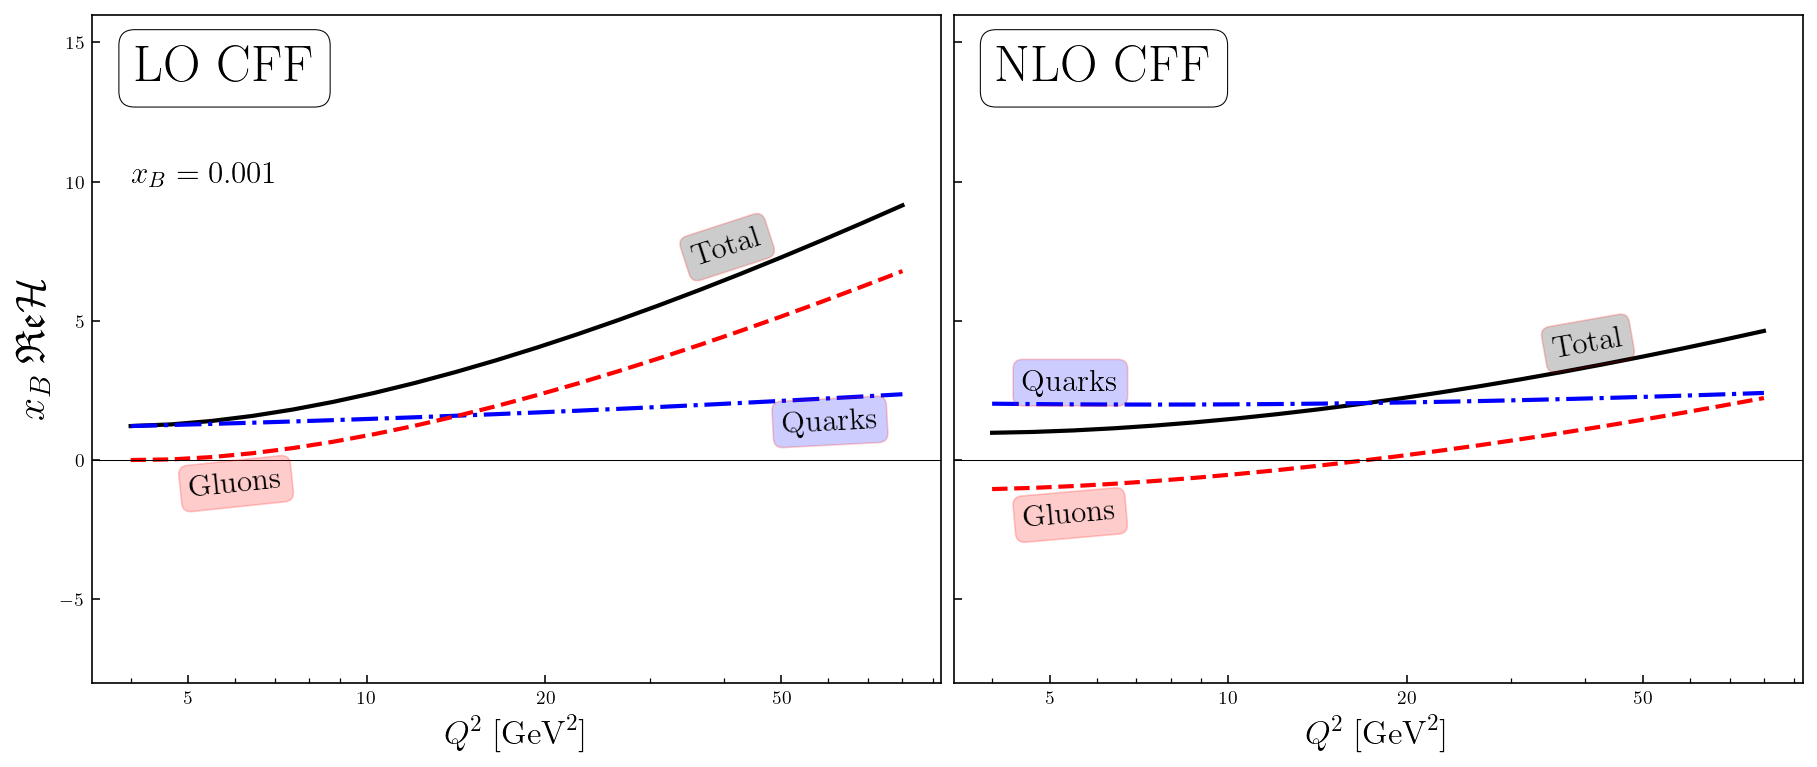

In [115]:
lw=2
fig, axs = plt.subplots(1, 2, figsize=[12, 5], sharey=True)
ax1, ax2 = axs
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ReHs[:,0,ln], styles[ln], lw=lw,
             label='LO {}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-8, 16)
ax1.axhline(y=0, linewidth=0.5, color='k')
ax1.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax1.set_ylabel(r'$x_B\:  \mathfrak{Re}\mathcal{H}$', fontsize=20)
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(4, 10, r'$x_B = {}$'.format(xB), fontsize=15)
ax1.text(35, 7.0, "Total", size=15, rotation=18.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax1.text(50, 1.0, "Quarks", size=15, rotation=3.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax1.text(5, -1.3, "Gluons", size=15, rotation=6.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax1.text(0.05, 0.9, "LO CFF", size=TITLESIZE,
         bbox=titlebox, transform=ax1.transAxes)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ReHs[:,1,ln], styles[ln], lw=lw,
             label='NLO {}'.format(names[ln]))
ax2.set_xscale('log')
# ax2.set_ylim(0, 2.5)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax2.text(35, 3.7, "Total", size=15, rotation=10.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax2.text(4.5, 2.5, "Quarks", size=15, rotation=0.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax2.text(4.5, -2.4, "Gluons", size=15, rotation=5.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax2.text(0.05, 0.9, "NLO CFF", size=TITLESIZE,
         bbox=titlebox, transform=ax2.transAxes)
fig.canvas.draw()

In [116]:
# fig.savefig('{}/QvsG_DVCS_real.pdf'.format(FIGDIR))
# fig.savefig('{}/QvsG_DVCS_real.png'.format(FIGDIR))

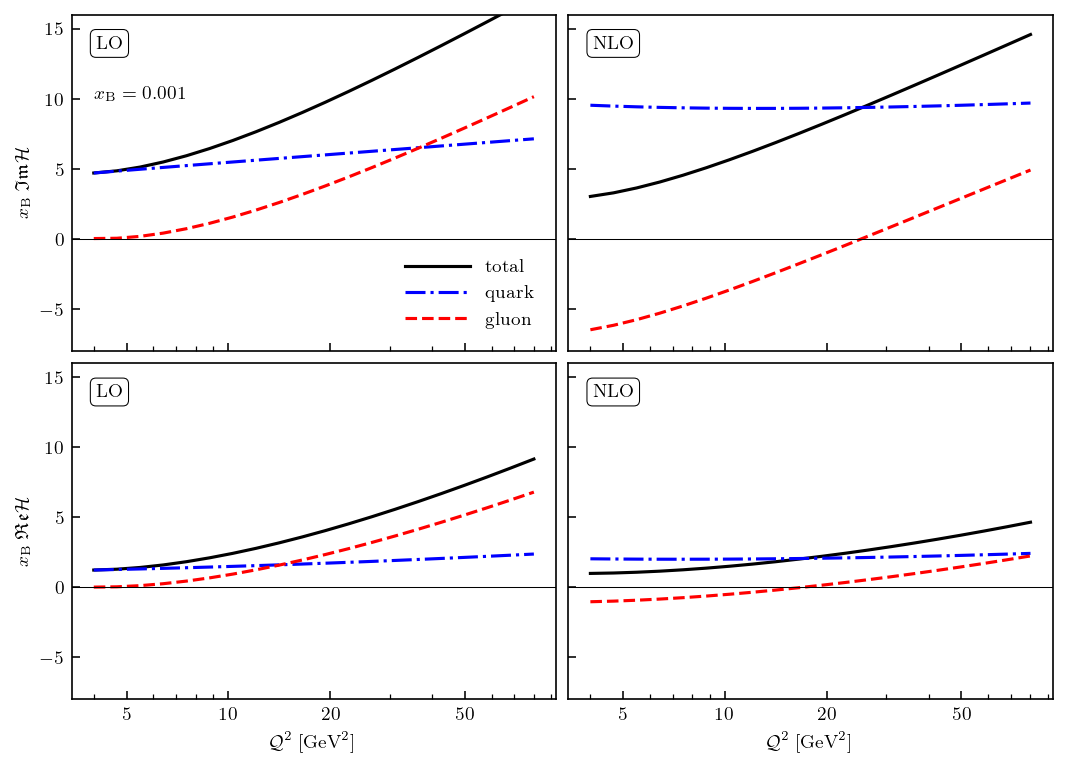

In [117]:
# Previous two plots on the single 2x2 plot
fig, (axs_up, axs_low) = plt.subplots(2, 2, figsize=[7, 5], sharey='row', sharex=True)
ax1, ax2 = axs_up
lw = 1.5
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ImHs[:,0,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-8, 16)
ax1.axhline(y=0, linewidth=0.5, color='k')
# ax1.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax1.set_ylabel(r'$x_{{\textup{{B}}}}\:  \mathfrak{Im}\mathcal{H}$')
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(4, 10, r'$x_{{\textup{{B}}}} = {}$'.format(xB))
ax1.text(0.05, 0.9, "LO", bbox=titlebox, transform=ax1.transAxes)
ax1.legend(loc='lower right', handlelength=3.5)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ImHs[:,1,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax2.set_xscale('log')
# ax2.set_ylim(0, 2.5)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
# ax2.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax2.text(0.05, 0.9, "NLO", bbox=titlebox, transform=ax2.transAxes)
# lower two panels
ax1, ax2 = axs_low
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ReHs[:,0,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-8, 16)
ax1.axhline(y=0, linewidth=0.5, color='k')
ax1.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
ax1.set_ylabel(r'$x_{{\textup{{B}}}}\:  \mathfrak{Re}\mathcal{H}$')
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
# ax1.text(4, 10, r'$x_B = {}$'.format(xB))
ax1.text(0.05, 0.9, "LO", bbox=titlebox, transform=ax1.transAxes)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ReHs[:,1,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax2.set_xscale('log')
# ax2.set_ylim(0, 2.5)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
ax2.text(0.05, 0.9, "NLO", bbox=titlebox, transform=ax2.transAxes)
fig.canvas.draw()

In [118]:
fig.savefig('{}/QvsG_DVCS.pdf'.format(FIGDIR))
# fig.savefig('{}/QvsG_DVCS.png'.format(FIGDIR))

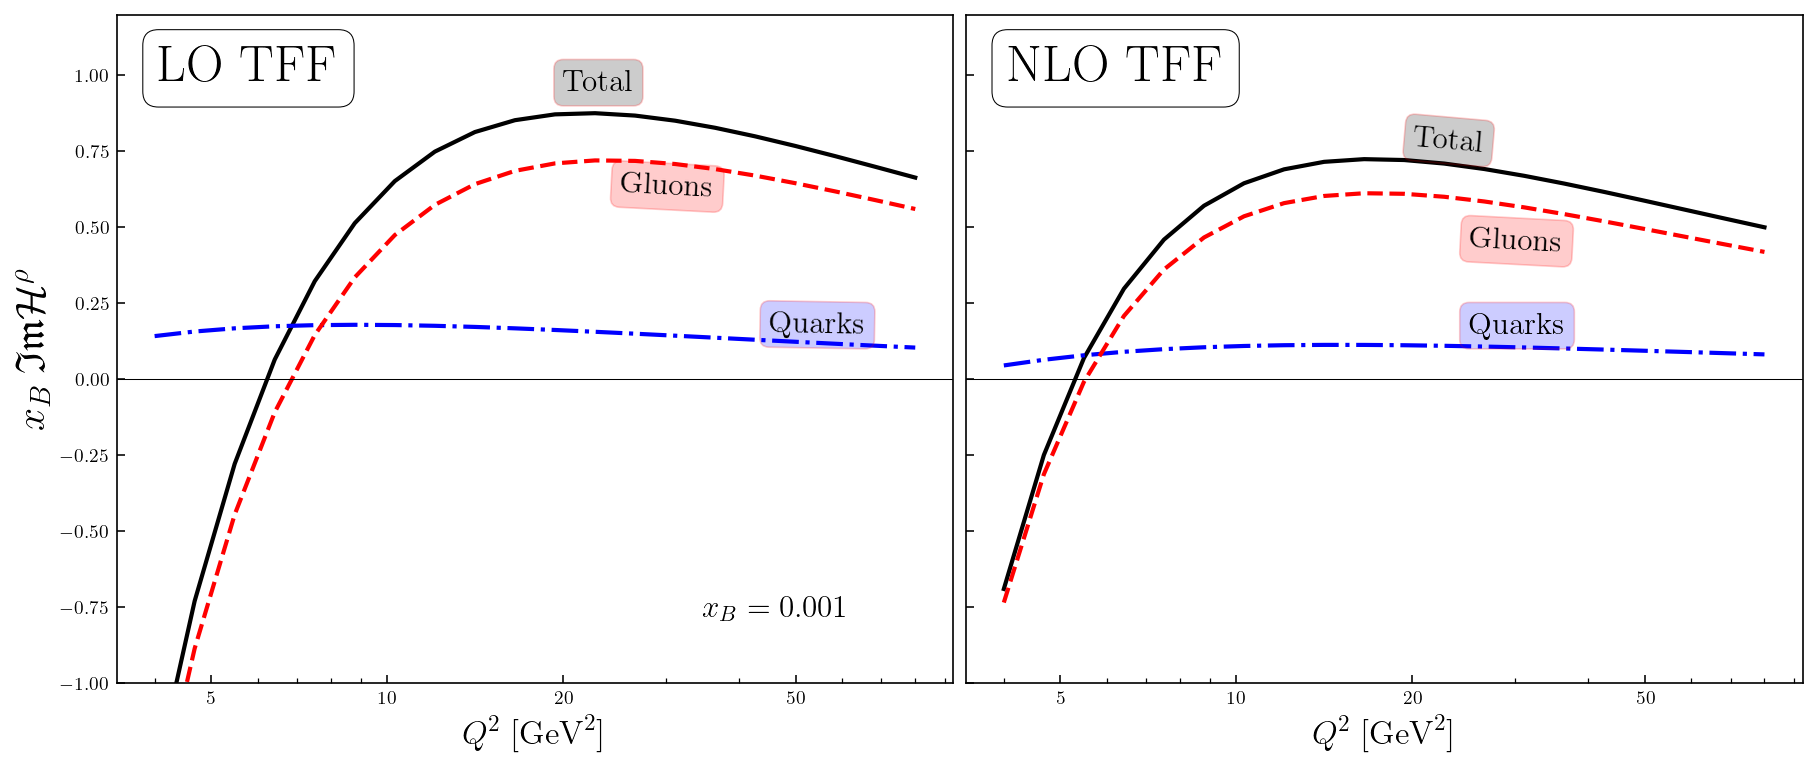

In [119]:
lw=2
fig, axs = plt.subplots(1, 2, figsize=[12, 5], sharey=True)
ax1, ax2 = axs
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ImHVs[:,0,ln], styles[ln], lw=lw,
             label='LO {}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-1, 1.2)
ax1.axhline(y=0, linewidth=0.5, color='k')
ax1.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax1.set_ylabel(r'$x_B\:  \mathfrak{Im}\mathcal{H}^\rho$', fontsize=20)
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(0.7, 0.1, r'$x_B = {}$'.format(xB), fontsize=15, transform=ax1.transAxes)
ax1.text(20, 0.95, "Total", size=15, rotation=0.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax1.text(45, 0.15, "Quarks", size=15, rotation=-1.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax1.text(25, 0.6, "Gluons", size=15, rotation=-3.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax1.text(0.05, 0.9, "LO TFF", size=TITLESIZE,
         bbox=titlebox, transform=ax1.transAxes)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ImHVs[:,1,ln], styles[ln], lw=lw,
             label='NLO {}'.format(names[ln]))
ax2.set_xscale('log')
# ax2.set_ylim(-0.15, 0.5)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax2.text(20, 0.75, "Total", size=15, rotation=-5.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax2.text(25, 0.15, "Quarks", size=15, rotation=0.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax2.text(25, 0.42, "Gluons", size=15, rotation=-3.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax2.text(0.05, 0.9, "NLO TFF", size=TITLESIZE,
         bbox=titlebox, transform=ax2.transAxes)
fig.canvas.draw()

In [120]:
# fig.savefig('{}/QvsG_DVMP_imag.pdf'.format(FIGDIR))
# fig.savefig('{}/QvsG_DVMP_imag.png'.format(FIGDIR))

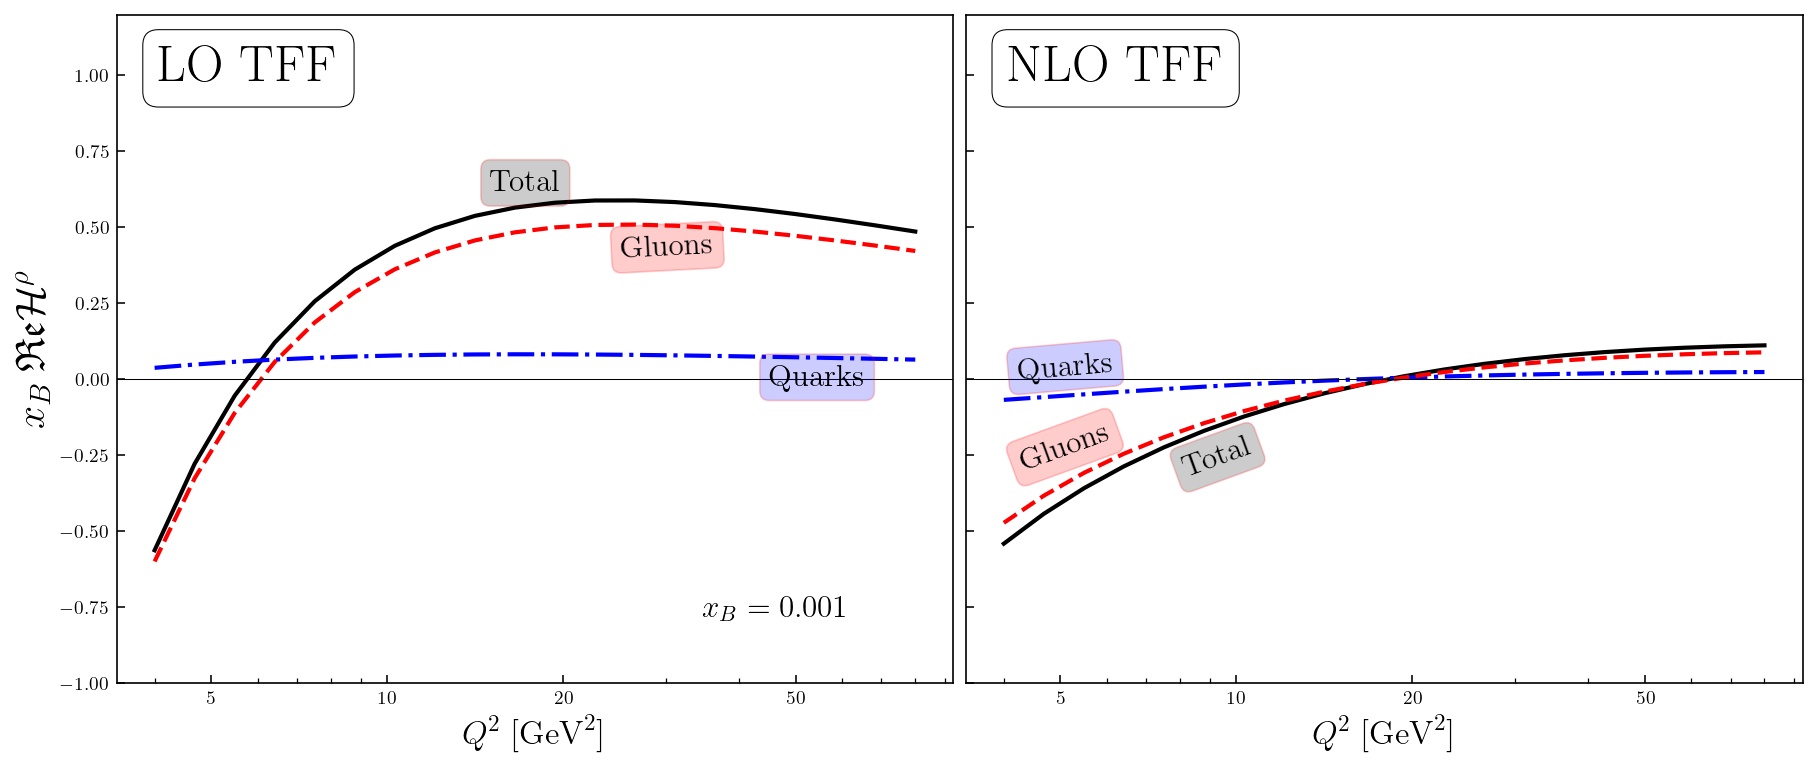

In [121]:
lw=2
fig, axs = plt.subplots(1, 2, figsize=[12, 5], sharey=True)
ax1, ax2 = axs
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ReHVs[:,0,ln], styles[ln], lw=lw,
             label='LO {}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-1, 1.2)
ax1.axhline(y=0, linewidth=0.5, color='k')
ax1.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax1.set_ylabel(r'$x_B\:  \mathfrak{Re}\mathcal{H}^\rho$', fontsize=20)
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(0.7, 0.1, r'$x_B = {}$'.format(xB), fontsize=15, transform=ax1.transAxes)
ax1.text(15, 0.62, "Total", size=15, rotation=0.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax1.text(45, -0.02, "Quarks", size=15, rotation=-0.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax1.text(25, 0.4, "Gluons", size=15, rotation=3.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax1.text(0.05, 0.9, "LO TFF", size=TITLESIZE,
         bbox=titlebox, transform=ax1.transAxes)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ReHVs[:,1,ln], styles[ln], lw=lw,
             label='NLO {}'.format(names[ln]))
ax2.set_xscale('log')
# ax2.set_ylim(-0.15, 0.5)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
ax2.text(8, -0.32, "Total", size=15, rotation=20.,
         bbox=dict(boxstyle="round", ec="red", fc="black", alpha=0.2))
ax2.text(4.2, -0.0, "Quarks", size=15, rotation=5.,
         bbox=dict(boxstyle="round", ec="red", fc="blue", alpha=0.2))
ax2.text(4.2, -0.3, "Gluons", size=15, rotation=20.,
         bbox=dict(boxstyle="round", ec="red", fc="red", alpha=0.2))
ax2.text(0.05, 0.9, "NLO TFF", size=TITLESIZE,
         bbox=titlebox, transform=ax2.transAxes)
fig.canvas.draw()

In [122]:
# fig.savefig('{}/QvsG_DVMP_real.pdf'.format(FIGDIR))
# fig.savefig('{}/QvsG_DVMP_real.png'.format(FIGDIR))

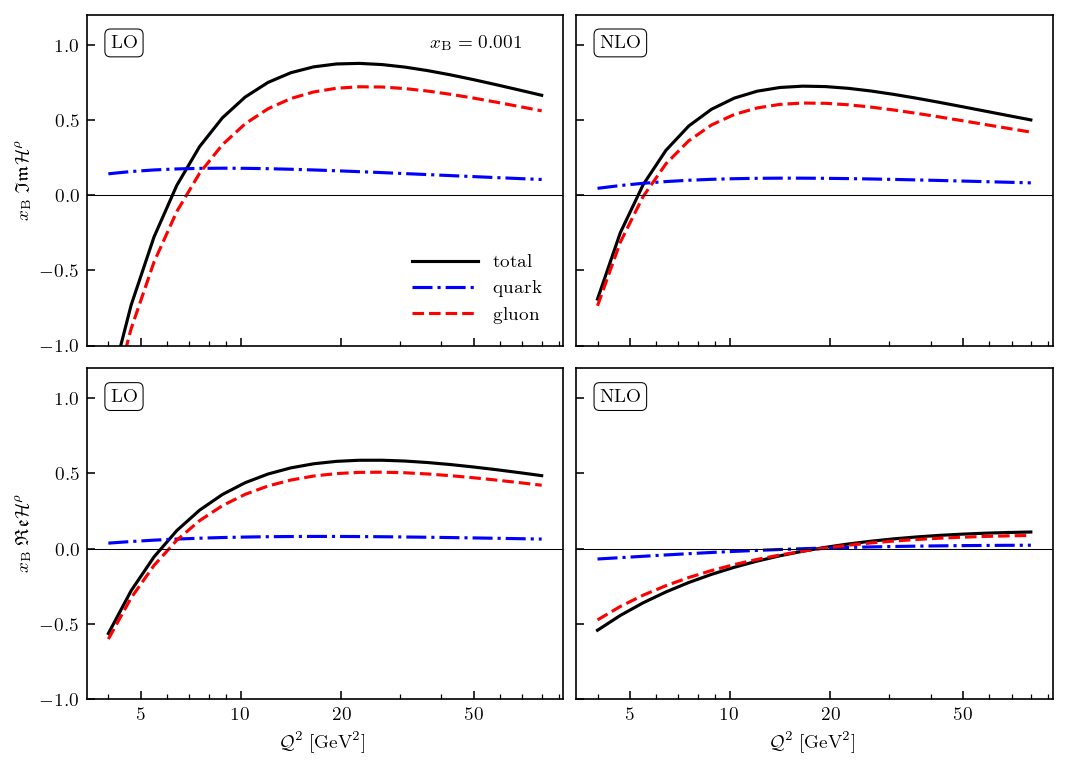

In [123]:
lw=1.5
fig, (axs_up, axs_low) = plt.subplots(2, 2, figsize=[7, 5], sharey='row', sharex=True)
ax1, ax2 = axs_up
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ImHVs[:,0,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-1, 1.2)
ax1.axhline(y=0, linewidth=0.5, color='k')
ax1.set_ylabel(r'$x_{{\textup{{B}}}}\:  \mathfrak{Im}\mathcal{H}^\rho$')
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(0.72, 0.9, r'$x_{{\textup{{B}}}} = {}$'.format(xB), transform=ax1.transAxes)
ax1.text(0.05, 0.9, "LO", bbox=titlebox, transform=ax1.transAxes)
ax1.legend(loc='lower right', handlelength=3.5)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ImHVs[:,1,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax2.set_xscale('log')
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.text(0.05, 0.9, "NLO", bbox=titlebox, transform=ax2.transAxes)
# lower panels
ax1, ax2 = axs_low
names = ['total', 'quark', 'gluon']
styles = ['k-', 'b-.', 'r--']
for ln in range(3):
    ax1.plot(Q2vals, xB*ReHVs[:,0,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax1.set_xscale('log')
ax1.set_ylim(-1, 1.2)
ax1.axhline(y=0, linewidth=0.5, color='k')
ax1.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
ax1.set_ylabel(r'$x_{{\textup{{B}}}}\:  \mathfrak{Re}\mathcal{H}^\rho$')
ax1.set_xticks([5, 10, 20, 50])
ax1.set_xticklabels(['5','10','20','50'])
ax1.text(0.05, 0.9, "LO", bbox=titlebox, transform=ax1.transAxes)
#
for ln in range(3):
    ax2.plot(Q2vals, xB*ReHVs[:,1,ln], styles[ln], lw=lw,
             label='{}'.format(names[ln]))
ax2.set_xscale('log')
# ax2.set_ylim(-0.15, 0.5)
ax2.set_xticks([5, 10, 20, 50])
ax2.set_xticklabels(['5','10','20','50'])
ax2.axhline(y=0, linewidth=0.5, color='k')
ax2.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
ax2.text(0.05, 0.9, "NLO", bbox=titlebox, transform=ax2.transAxes)
fig.canvas.draw()

In [124]:
fig.savefig('{}/QvsG_DVMP.pdf'.format(FIGDIR))
# fig.savefig('{}/QvsG_DVMP.png'.format(FIGDIR))

# Plot - Skewness

In [125]:
%%time
NPTS = 20
xB = 0.002
xi = xB/2
Q2vals = np.logspace(np.log10(3.), np.log10(80), NPTS)
for th in THEORIES:
    skews = []
    for Q2 in Q2vals:
        ptt = g.DataPoint(x=xi, eta=xi, t=0, Q2=Q2)
        skews.append(th.skewness_Hx(ptt))
    th.skews = np.array(skews)

CPU times: user 2min 19s, sys: 29.5 ms, total: 2min 19s
Wall time: 2min 20s


In [126]:
def skewness_fig(ths, draft=False):
    fig, axs = plt.subplots(1, 2, figsize=[7, 3])
    ax1, ax2 = axs
    for th in ths:
        ax1.plot(Q2vals, th.skews[:, 0], label=th.name, **th.props)
    ax1.set_xscale('log')
    # ax1.set_ylim(-1, 2.5)
    ax1.axhline(y=0, linewidth=0.5, color='k')
    ax1.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
    ax1.set_ylabel('skewness ratio $H(x,x)/H(x,0)$')
    ax1.set_xticks([5, 10, 20, 50])
    ax1.set_xticklabels(['5','10','20','50'])
    ax1.text(20, 0.5, r'$x = {}$'.format(xi))
    ax1.text(0.83, 0.92, "Quarks", transform=ax1.transAxes,
             bbox=titlebox)
    for th in ths:
        ax2.plot(Q2vals, th.skews[:, 1], label=th.name, **th.props)
    ax2.set_xscale('log')
    # ax2.set_ylim(-1, 2.5)
    ax2.set_xticks([5, 10, 20, 50])
    ax2.set_xticklabels(['5','10','20','50'])
    ax2.legend(loc='lower right', handlelength=4)#.draw_frame(0)
    ax2.axhline(y=0, linewidth=0.5, color='k')
    ax2.text(0.83, 0.92, "Gluons", transform=ax2.transAxes,
             bbox=titlebox)
    ax2.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
    fig.canvas.draw()
    return fig

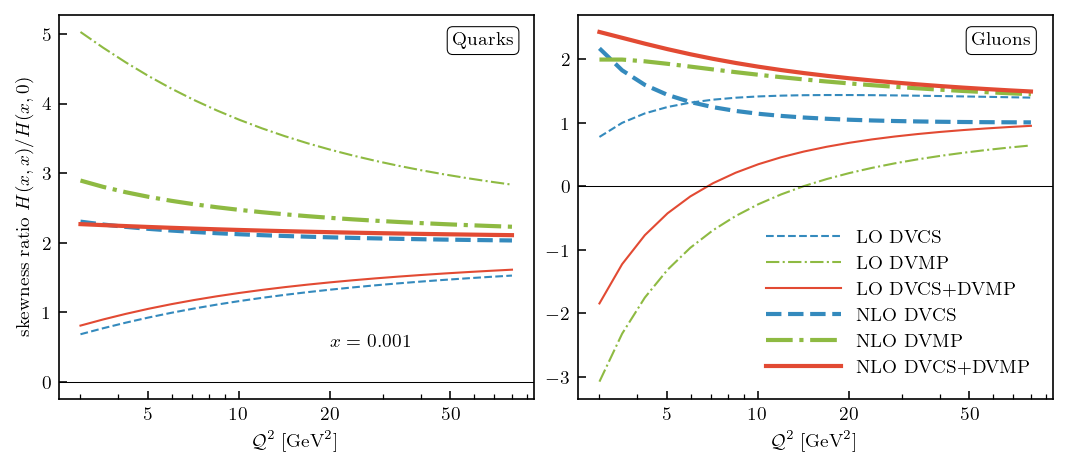

In [127]:
fig = skewness_fig(THEORIES)

In [128]:
fig.savefig('{}/lo_vs_nlo_skewness.pdf'.format(FIGDIR))
# fig.savefig('{}/lo_vs_nlo_skewness.png'.format(FIGDIR))

Let's also see $\xi$ dependence of skewness:

In [129]:
%%time
NPTS = 10
xivals = np.logspace(np.log10(1e-5), np.log10(0.3), NPTS)
for th in THEORIES:
    xiskews = []
    for xi in xivals:
        ptt = g.DataPoint(x=xi, eta=xi, t=0, Q2=4.)
        xiskews.append(th.skewness_Hx(ptt))
    th.xiskews = np.array(xiskews)

CPU times: user 1min 8s, sys: 26.4 ms, total: 1min 8s
Wall time: 1min 9s


In [130]:
def xi_skewness_fig(ths, draft=False, decoration=False):
    if decoration:
        textbox = dict(boxstyle="round", ec="black", lw=4, fc="black", alpha=0.2)
    else:
        textbox = dict(boxstyle="square", alpha=0)
    fig, axs = plt.subplots(1, 2, figsize=[14,6])
    ax1, ax2 = axs
    for th in ths:
        ax1.plot(xivals, th.xiskews[:, 0], label=th.name, **th.props)
    ax1.set_xscale('log')
    # ax1.set_ylim(-1, 2.5)
    ax1.set_xlim(1e-5, 0.1)
    ax1.axhline(y=0, linewidth=0.5, color='k')
    ax1.set_xlabel(r'$\xi$', fontsize=16)
    ax1.set_ylabel('skewness ratio $H(x,x)/H(x,0)$', fontsize=16)
    # ax1.set_xticks([5, 10, 20, 50])
    # ax1.set_xticklabels(['5','10','20','50'])
    # ax1.text(20, 0.5, r'$x = {}$'.format(xi), fontsize=15)
    ax1.text(0.7, 0.9, "Quarks", size=20, transform=ax1.transAxes,
             bbox=textbox)
    for th in ths:
        ax2.plot(xivals, th.xiskews[:, 1], label=th.name, **th.props)
    ax2.set_xscale('log')
    # ax2.set_ylim(-1, 2.5)
    # ax2.set_xticks([5, 10, 20, 50])
    # ax2.set_xticklabels(['5','10','20','50'])
    ax2.legend(loc='lower right', handlelength=3, fontsize=16).draw_frame(0)
    ax2.axhline(y=0, linewidth=0.5, color='k')
    ax2.text(0.7, 0.9, "Gluons", size=20, transform=ax2.transAxes,
             bbox=textbox)
    ax2.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=16)
    ax2.set_xlim(1e-5, 0.1)
    fig.canvas.draw()
    return fig

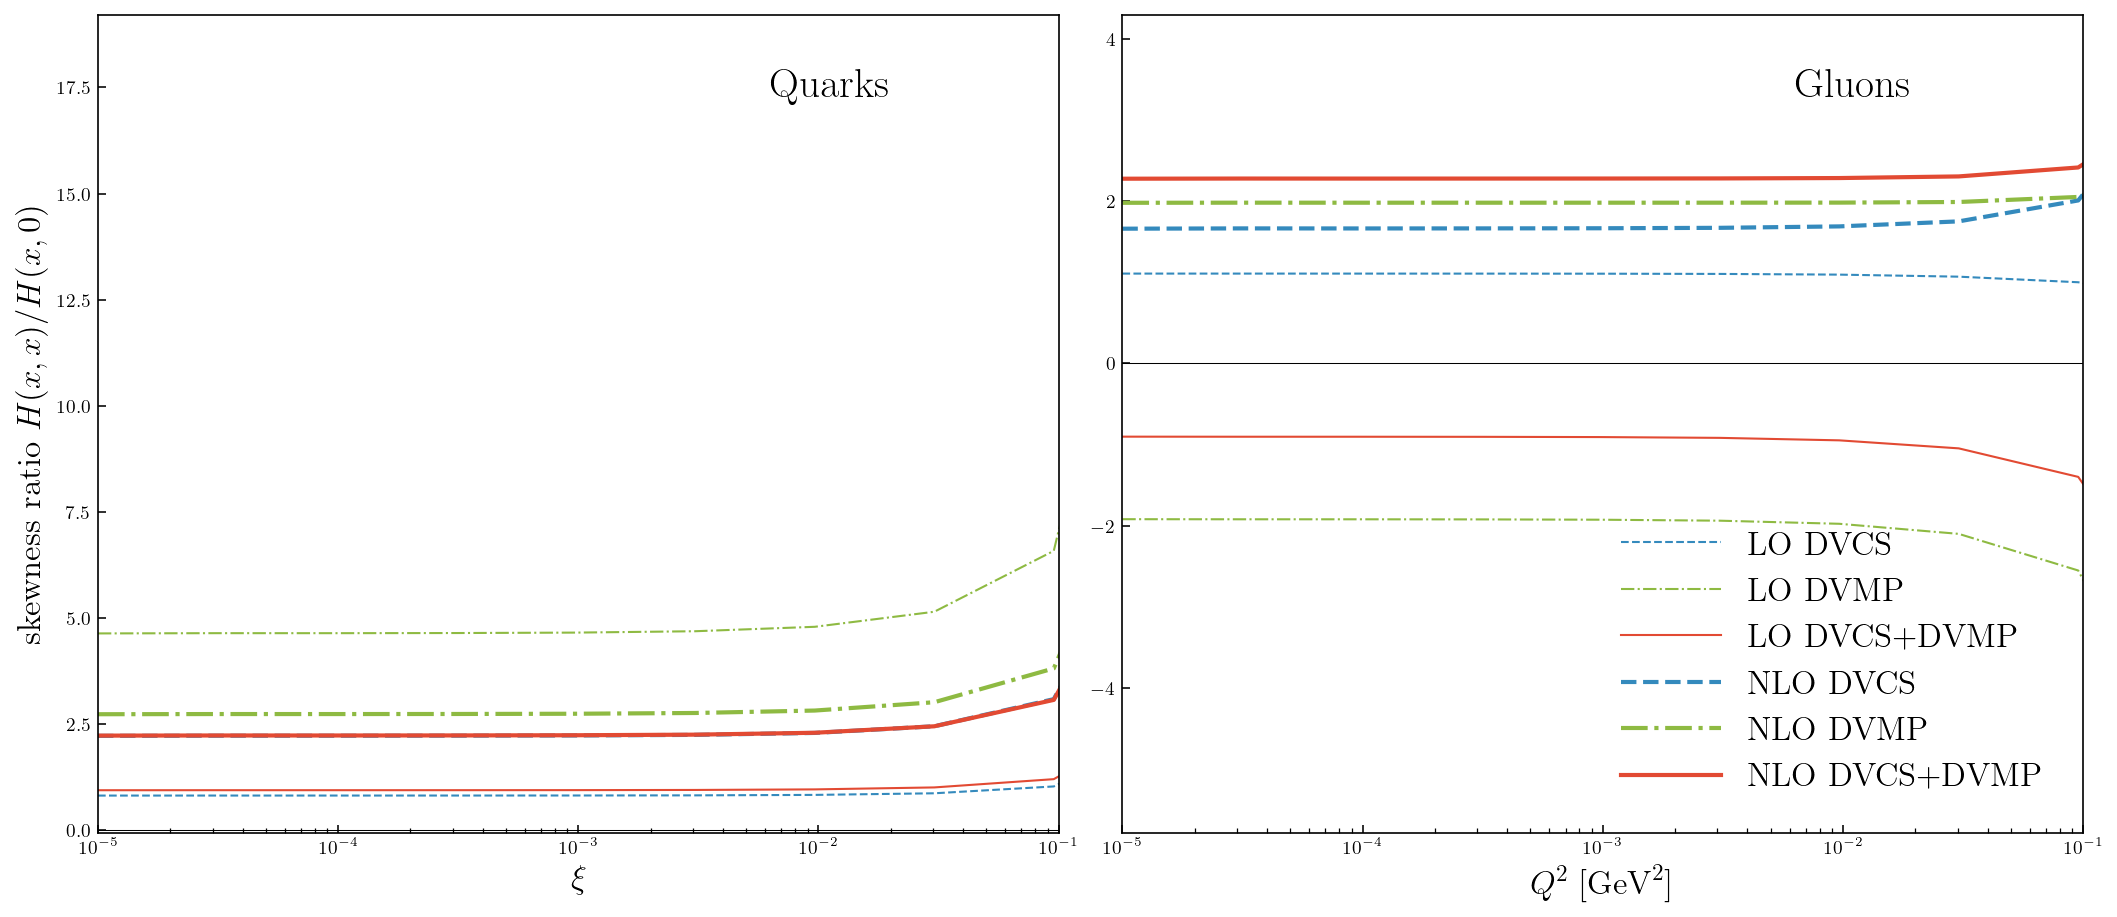

In [131]:
fig = xi_skewness_fig(THEORIES)